# 2nd order neurons SNN

In [1]:
import GenEvents as ge
import PlotEvents as pe
import EventData as ed
import Params as ps

In [2]:
import numpy as np
import tqdm 
import math
import matplotlib.pyplot as plt

import snntorch as snn
import torch
import torch.nn as nn

import snntorch.spikeplot as splt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate

from snntorch import spikegen

import torch.nn.functional as F

import matplotlib.pyplot as plt
import snntorch.spikeplot as splt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

/home/andrea/anaconda3/envs/torch/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449229234/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Preprocessing 

In [3]:
num_events = 30000
num_events_test = 6000

events_arr, muon_list, max_n = ge.generate_noisy_evts(num_events, noise_frac=1, bkg_frac=0.5)
events_arr_test, muon_list_test, max_n_test = ge.generate_noisy_evts(num_events_test, noise_frac=1, bkg_frac=0.5)

100%|██████████████████████████████████████| 6000/6000 [00:07<00:00, 785.03it/s]


In [4]:
'''
def get_target_train(muon_list):
    
    target_list = []
    for event in muon_list:
        true_event = []
        for hit in event:
            if hit['signal'] == True:
                true_event.append(hit)
            
            target_list.append(true_event)
    
    return target_list

target = get_target_train(muon_list)
target_test = get_target_train(muon_list_test)
'''

"\ndef get_target_train(muon_list):\n    \n    target_list = []\n    for event in muon_list:\n        true_event = []\n        for hit in event:\n            if hit['signal'] == True:\n                true_event.append(hit)\n            \n            target_list.append(true_event)\n    \n    return target_list\n\ntarget = get_target_train(muon_list)\ntarget_test = get_target_train(muon_list_test)\n"

In [5]:
def gen_target(muon_list):
    target = np.zeros(shape=(len(muon_list), ps.NLAYERS, ps.NWIRES), dtype=np.int16)
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            layer, wire = hit['layer']-1, hit['wire_num']-1

            if hit['signal'] == True:
                target[i, layer, wire] = 1

    return torch.tensor(target, dtype=torch.float32)

target = gen_target(muon_list)
target_test = gen_target(muon_list_test)

30000it [00:00, 717817.61it/s]
6000it [00:00, 768023.44it/s]


In [6]:
'''
class CustomDataset(Dataset):
    def __init__(self, input_data, target, transform=None):
        self.input_data = input_data
        self.target = target
        
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        
        input_sample = self.input_data[idx]
        target_sample = self.target[idx]
        
        if self.transform:
            input_sample = self.transform(input_sample)
            target_sample = self.transform(target_sample)
            
        return input_sample, target_sample


# Transformations

# transform each event (muon_hits list) to np.array of fixed size
def convert_to(muon_hits, size, target_dtype=np.int16,
               features=['layer', 'wire_num', 'bx', 't0']):
    padded_array = np.zeros(shape=(size, len(features)), dtype=target_dtype)
    for i, hit in enumerate(muon_hits):
        for j, f in enumerate(features):
            padded_array[i,j] = hit[f]  # BEWARE: implicit type conversions going on here

    return padded_array

# converts to Torch tensor of desired type
def to_tensor_and_dtype(input_variable, target_dtype=torch.float32):
    
    # Convert to PyTorch tensor
    tensor = torch.tensor(input_variable)
    # Force the tensor to have the specified dtype
    tensor = tensor.to(target_dtype)
    
    return tensor

feature_list = ['layer', 'wire_num', 'bx', 't0']
transform = transforms.Compose([
    lambda x: convert_to(x, size=max_n, target_dtype=np.float32,
                         features=feature_list),
    lambda x: to_tensor_and_dtype(x, target_dtype=torch.float32)])
'''

"\nclass CustomDataset(Dataset):\n    def __init__(self, input_data, target, transform=None):\n        self.input_data = input_data\n        self.target = target\n        \n        self.transform = transform\n\n    def __len__(self):\n        return len(self.input_data)\n\n    def __getitem__(self, idx):\n        \n        input_sample = self.input_data[idx]\n        target_sample = self.target[idx]\n        \n        if self.transform:\n            input_sample = self.transform(input_sample)\n            target_sample = self.transform(target_sample)\n            \n        return input_sample, target_sample\n\n\n# Transformations\n\n# transform each event (muon_hits list) to np.array of fixed size\ndef convert_to(muon_hits, size, target_dtype=np.int16,\n               features=['layer', 'wire_num', 'bx', 't0']):\n    padded_array = np.zeros(shape=(size, len(features)), dtype=target_dtype)\n    for i, hit in enumerate(muon_hits):\n        for j, f in enumerate(features):\n            pa

In [7]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target, transform=None):
        self.input_data = input_data
        self.target = target
        
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        
        input_sample = self.input_data[idx]
        target_sample = self.target[idx]
        
        if self.transform:
            input_sample = self.transform(input_sample)
            
        return input_sample, target_sample


# Transformations

# transform each event (muon_hits list) to np.array of fixed size
def convert_to(muon_hits, size, bx0,target_dtype=np.int16,
               features=['layer', 'wire_num', 'bx', 't0']):
    
    starting_bx = min(bx0,min([x['bx'] for x in muon_hits]))
    padded_array = np.zeros(shape=(size, len(features)), dtype=target_dtype)
    
    for i, hit in enumerate(muon_hits):
        for j, f in enumerate(features):
            padded_array[i,j] = hit[f]  # BEWARE: implicit type conversions going on here
        
        padded_array[i,3] = starting_bx

    return padded_array

# converts to Torch tensor of desired type
def to_tensor_and_dtype(input_variable, target_dtype=torch.float32):
    
    # Convert to PyTorch tensor
    tensor = torch.tensor(input_variable)
    # Force the tensor to have the specified dtype
    tensor = tensor.to(target_dtype)
    
    return tensor

feature_list = ['layer', 'wire_num', 'bx', 't0']
transform = transforms.Compose([
    lambda x: convert_to(x, size=max_n, bx0=500,target_dtype=np.float32,
                         features=feature_list),
    lambda x: to_tensor_and_dtype(x, target_dtype=torch.float32)
])

In [8]:
train_dataset = CustomDataset(muon_list, target, transform=transform)
test_dataset = CustomDataset(muon_list_test, target_test, transform=transform)

batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=nw)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=nw)

## Input encoding and output decoding

In [9]:
def current_step(data_it, num_step=40,dur=1):
    spike_data = torch.zeros(size=(num_step,batch_size,ps.NLAYERS,ps.NWIRES), dtype=data_it.dtype)
    for n_batch, evt in enumerate(data_it):
        for hit in evt:
            layer = int(hit[0])
            wire = int(hit[1])
            bx = int(hit[2])
            t0 = math.floor(hit[3])
            if bx != 0:
                spike_data[bx-t0+ps.bx_oot:bx-t0+ps.bx_oot+dur, n_batch, layer-1, wire-1] = 1
            else:
                break
                
    return spike_data  

In [10]:
def train_decoding(batch_train):
    flatten_train = torch.sum(batch_train,0)
    
    flatten_train[flatten_train > 1] = 1
    
    return flatten_train

## Visualization 

In [11]:
def rec_tensor_plot(mem_rec,sample):
    # Generate Plots
    fig, ax = plt.subplots(mem_rec.shape[2], figsize=(16,16), sharex=True)

    for i in range(mem_rec.shape[2]):
        ax[i].plot(mem_rec[:,sample,i])

    plt.show()

In [12]:
def train_visualization(input_train, target_train):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for input_train
    axs[0].imshow(input_train, cmap='binary', interpolation='nearest')
    axs[0].set_title('Input Train')
    axs[0].set_xlabel('Timestep')
    axs[0].set_ylabel('Neurons')

    # Plot for target_train
    axs[1].imshow(target_train, cmap='binary', interpolation='nearest')
    axs[1].set_title('Target Train')
    axs[1].set_xlabel('Timestep')
    axs[1].set_ylabel('Neurons')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

In [13]:
# Temporal Dynamics
num_steps = 40

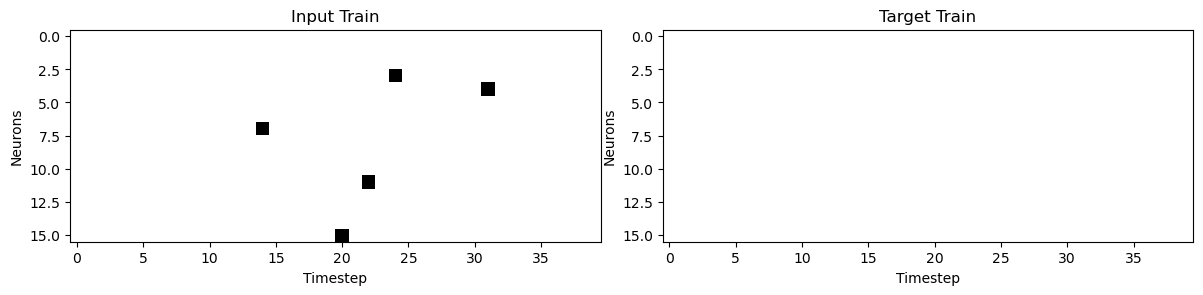

tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


In [14]:
train_batch = iter(train_loader)

for data_it, targets_it in train_batch:
    data_it = data_it.to(device)
    targets_it = targets_it.to(device)
    
    # create spike train
    spike_in = current_step(data_it, num_steps)
    spike_in = spike_in.to(device)
        
    spike_target = current_step(targets_it, num_steps)
    spike_target = spike_target.to(device)
    
    spike_in = spike_in.view(num_steps, batch_size, -1)
    spike_target = spike_target.view(num_steps, batch_size, -1)
    
    # target output works only with spike train targets
    train_visualization(torch.transpose(spike_in[:,0,:],0,1),torch.transpose(spike_target[:,0,:],0,1))
    
    print(targets_it.view(batch_size,-1)[0])
    
    break

In [15]:
print(muon_list[0])
print(target[0])

[{'layer': 2, 'wire_num': 4, 'bx': 504, 'tdc': 16, 'label': -1, 't0': 500.56666666666666, 'psi': -0.5413643420928658, 'x0': 53.515114503309036, 'signal': True}, {'layer': 3, 'wire_num': 4, 'bx': 512, 'tdc': 2, 'label': 0, 't0': 500.56666666666666, 'psi': -0.5413643420928658, 'x0': 53.515114503309036, 'signal': False}, {'layer': 4, 'wire_num': 4, 'bx': 510, 'tdc': 30, 'label': 0, 't0': 500.56666666666666, 'psi': -0.5413643420928658, 'x0': 53.515114503309036, 'signal': False}, {'layer': 2, 'wire_num': 1, 'bx': 521, 'tdc': 30, 'label': 0, 't0': 500.56666666666666, 'psi': -0.5413643420928658, 'x0': 53.515114503309036, 'signal': False}, {'layer': 1, 'wire_num': 4, 'bx': 514, 'tdc': 9, 'label': -1, 't0': 500.56666666666666, 'psi': -0.5413643420928658, 'x0': 53.515114503309036, 'signal': True}]
tensor([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])


## NETWORK

In [16]:
# Network Architecture
num_inputs = ps.NLAYERS*ps.NWIRES
num_hidden = 64
num_outputs = num_inputs

beta = 0.7
alpha=0.1

In [17]:
'''
class Net(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad)
        
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

num_hidden = 100

net = Net(num_inputs, num_hidden, num_outputs, num_steps).to(device)
'''

'\nclass Net(nn.Module):\n    """Simple spiking neural network in snntorch."""\n\n    def __init__(self, input_feat, hidden,out_feat,timesteps):\n        super().__init__()\n        \n        self.input_feat = input_feat # number of input neurons \n        self.hidden = hidden # number of hidden neurons\n        self.out_feat = out_feat # number of output neurons\n        \n        self.timesteps = timesteps # number of time steps to simulate the network\n        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function\n        \n        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)\n        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad)\n        \n        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)\n        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad)\n        \n    def forward(self, x):\n        """Forward pass for several time steps."""\n\n        # Initalize membrane potential\n      

In [18]:
class Net2order(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Synaptic(beta=beta,alpha=alpha,
                                   spike_grad=spike_grad,
                                   threshold=3.5)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=beta,alpha=alpha,
                                    spike_grad=spike_grad,
                                    threshold=3.5,reset_mechanism = 'zero')
        
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

net = Net2order(num_inputs, num_hidden, num_outputs, num_steps).to(device)

In [19]:
def accuracy(output,target):
    loss = 0
    for i,out in enumerate(output):
        if torch.equal(out,target[i]):
            loss += 1
    return loss

Iteration: 0
Train error: 4.174999713897705
Test error: 4.675000190734863

Some test examples:

Input: [0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
Target: [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


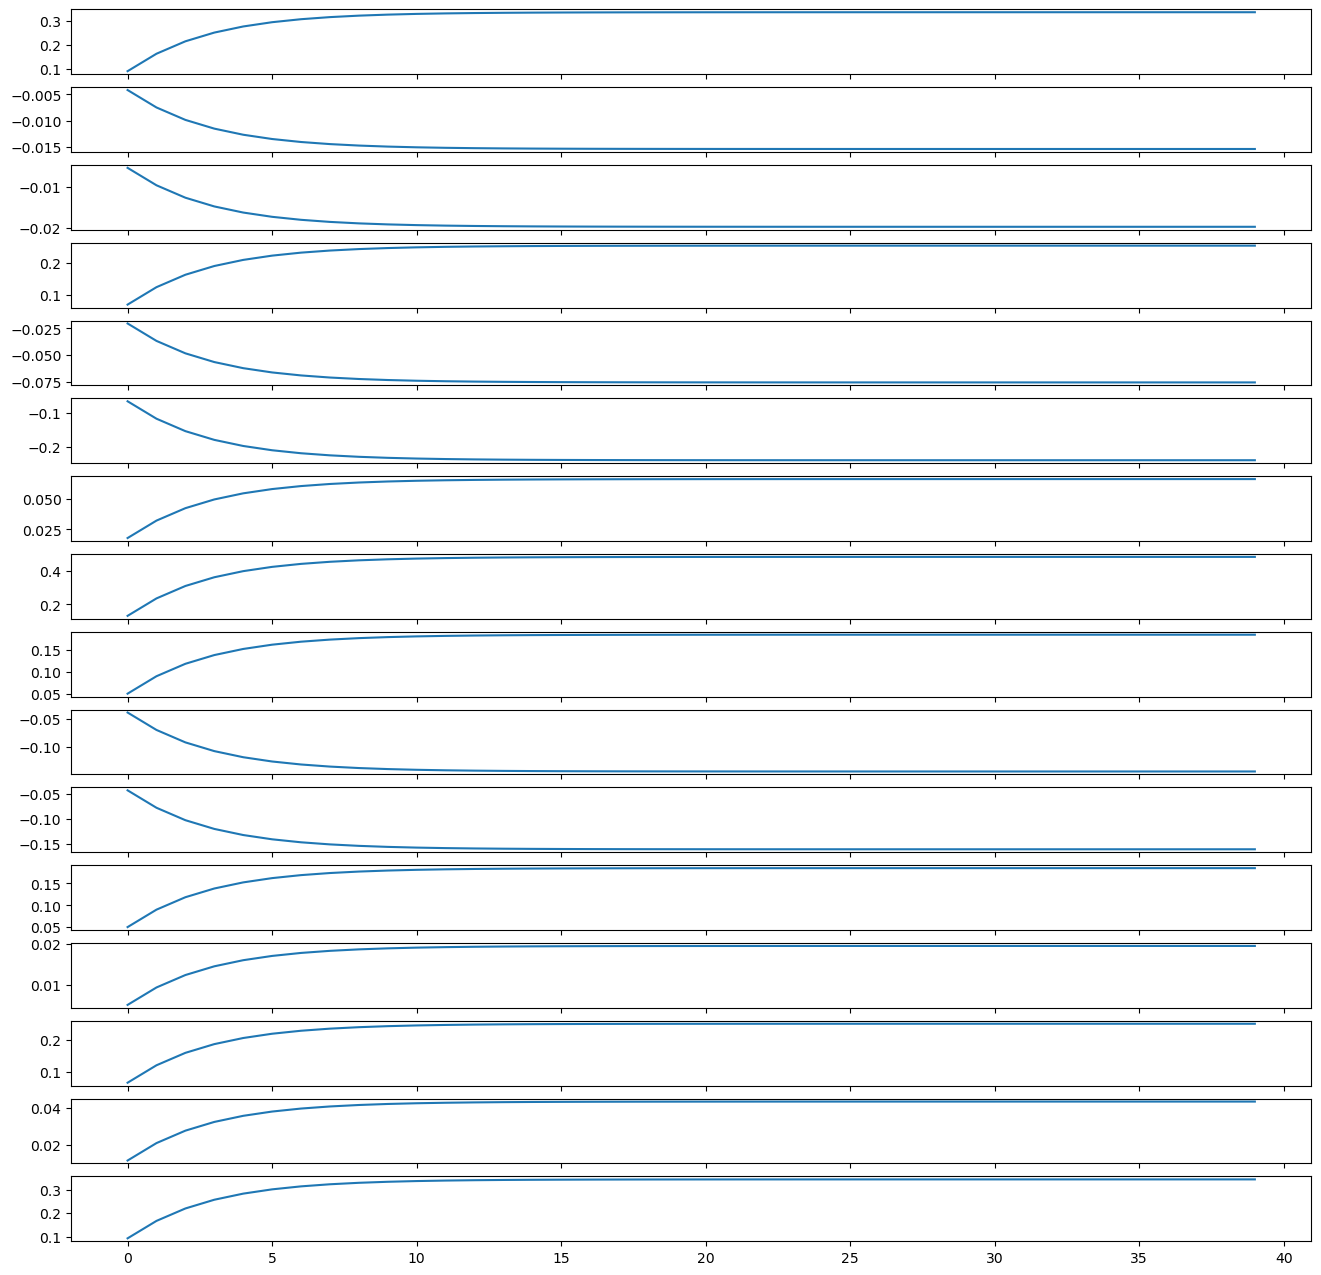


Input: [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Target: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


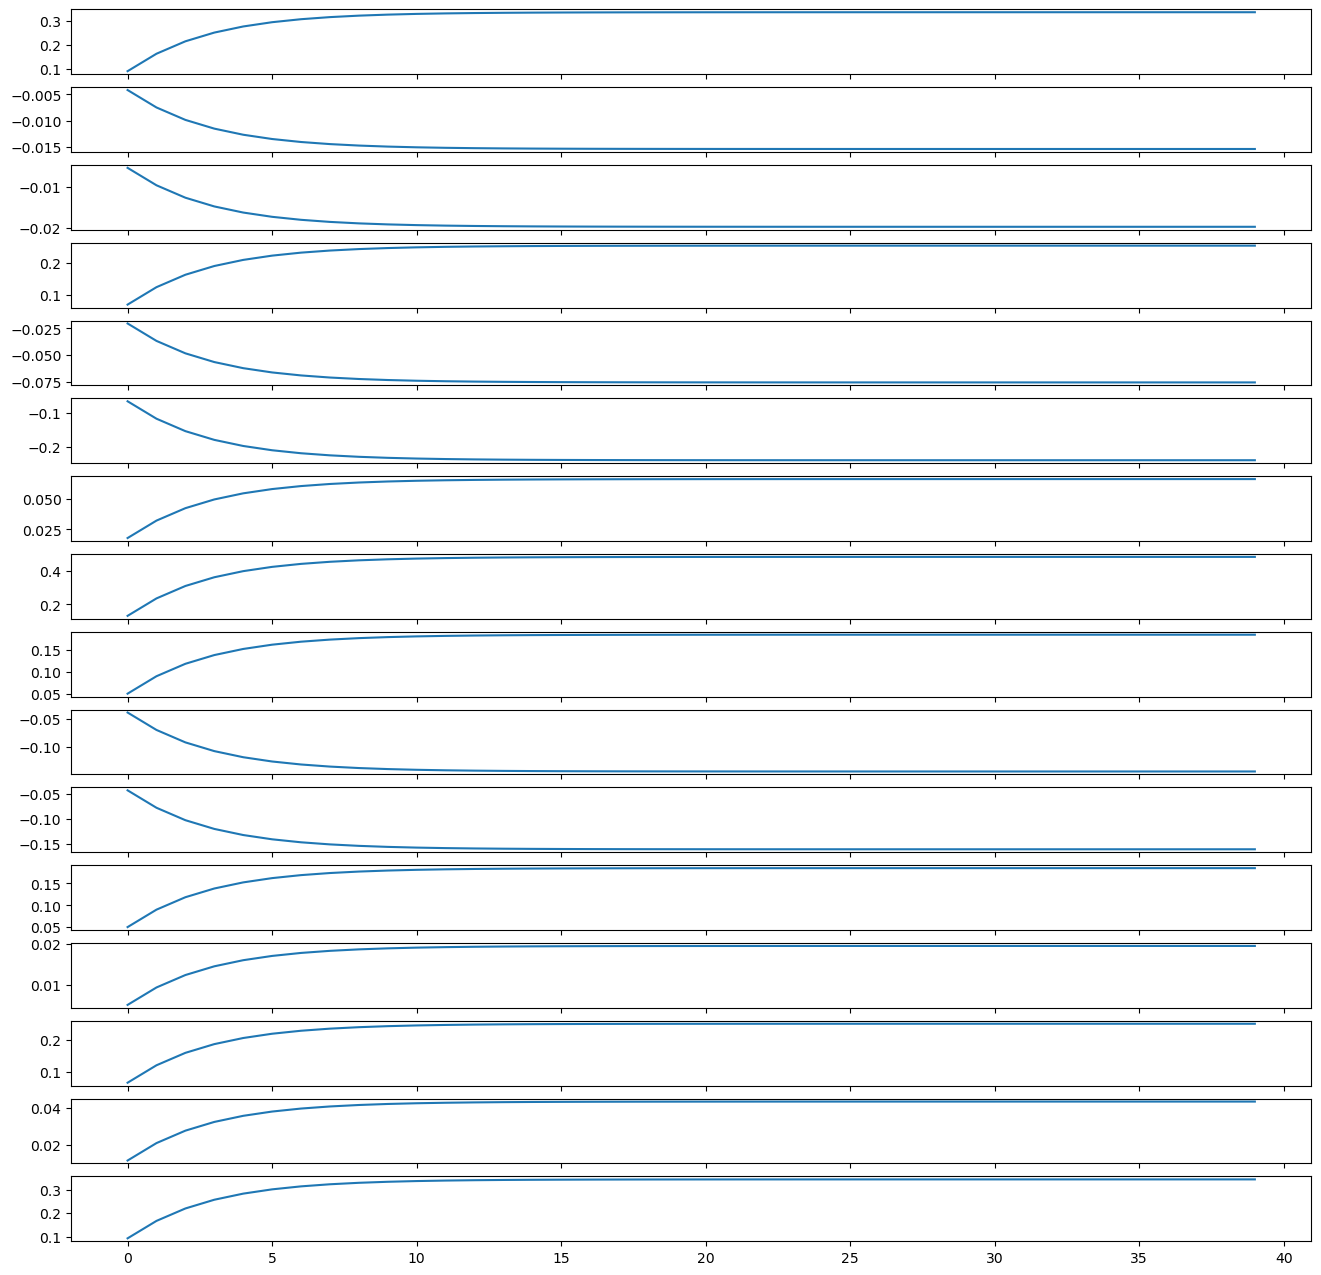


Input: [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
Target: [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


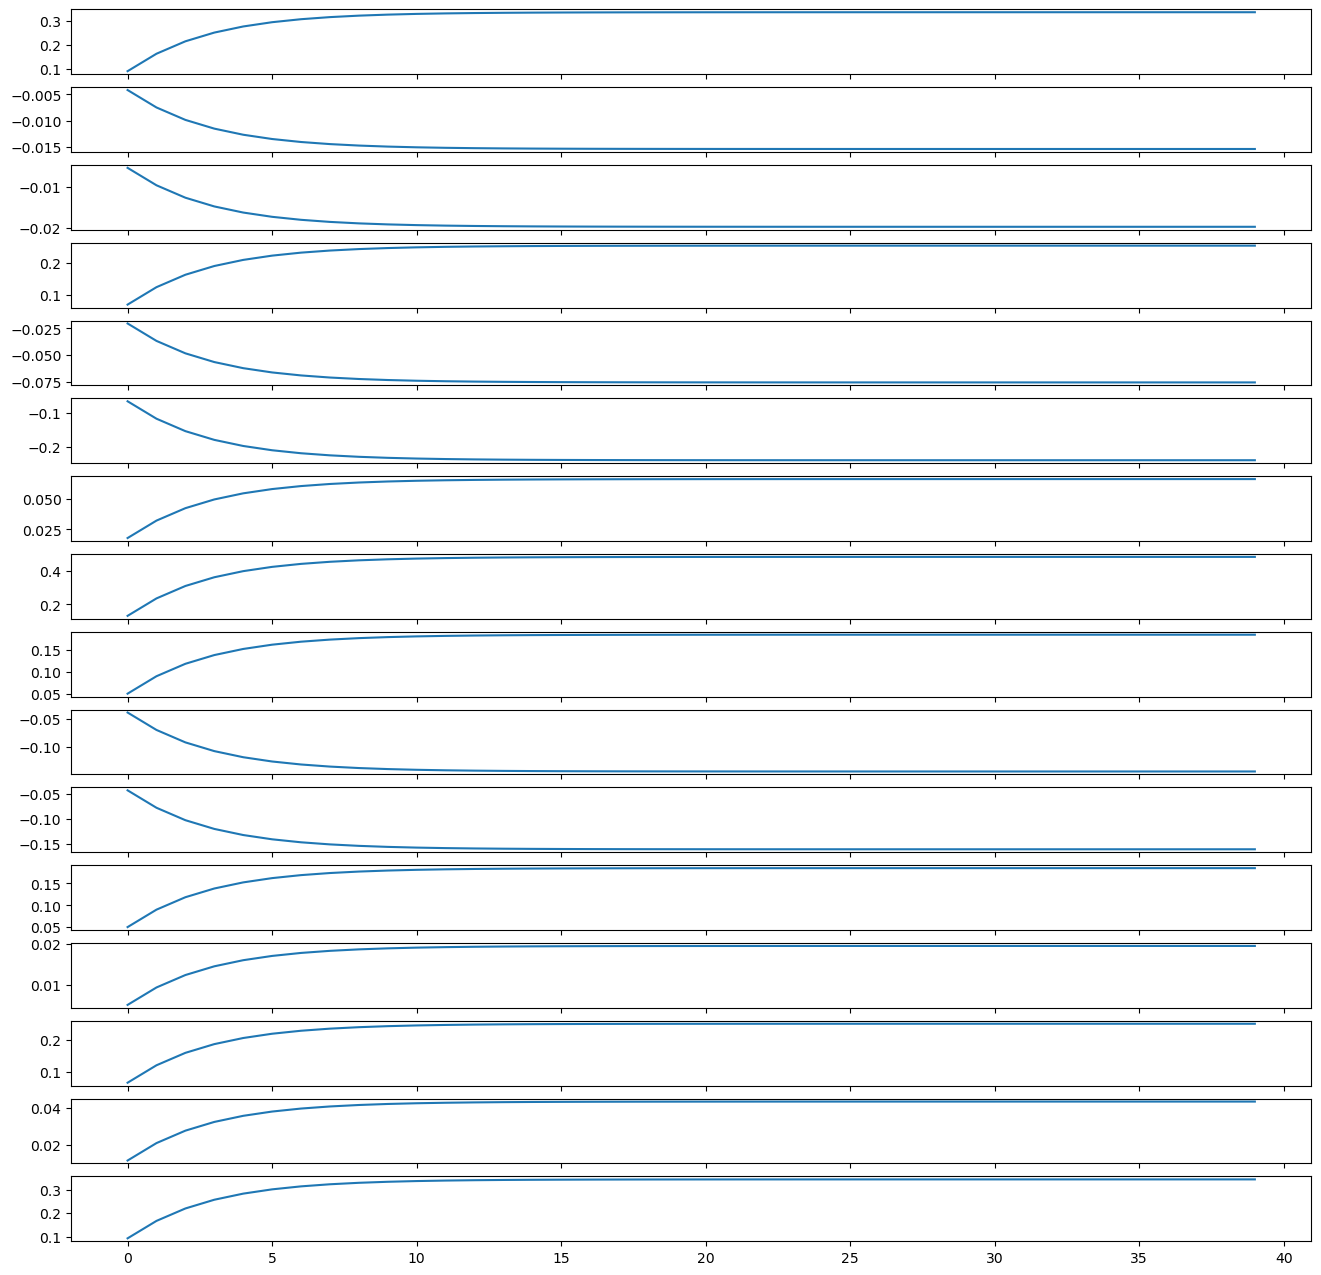


Input: [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0.]
Target: [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
Output: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


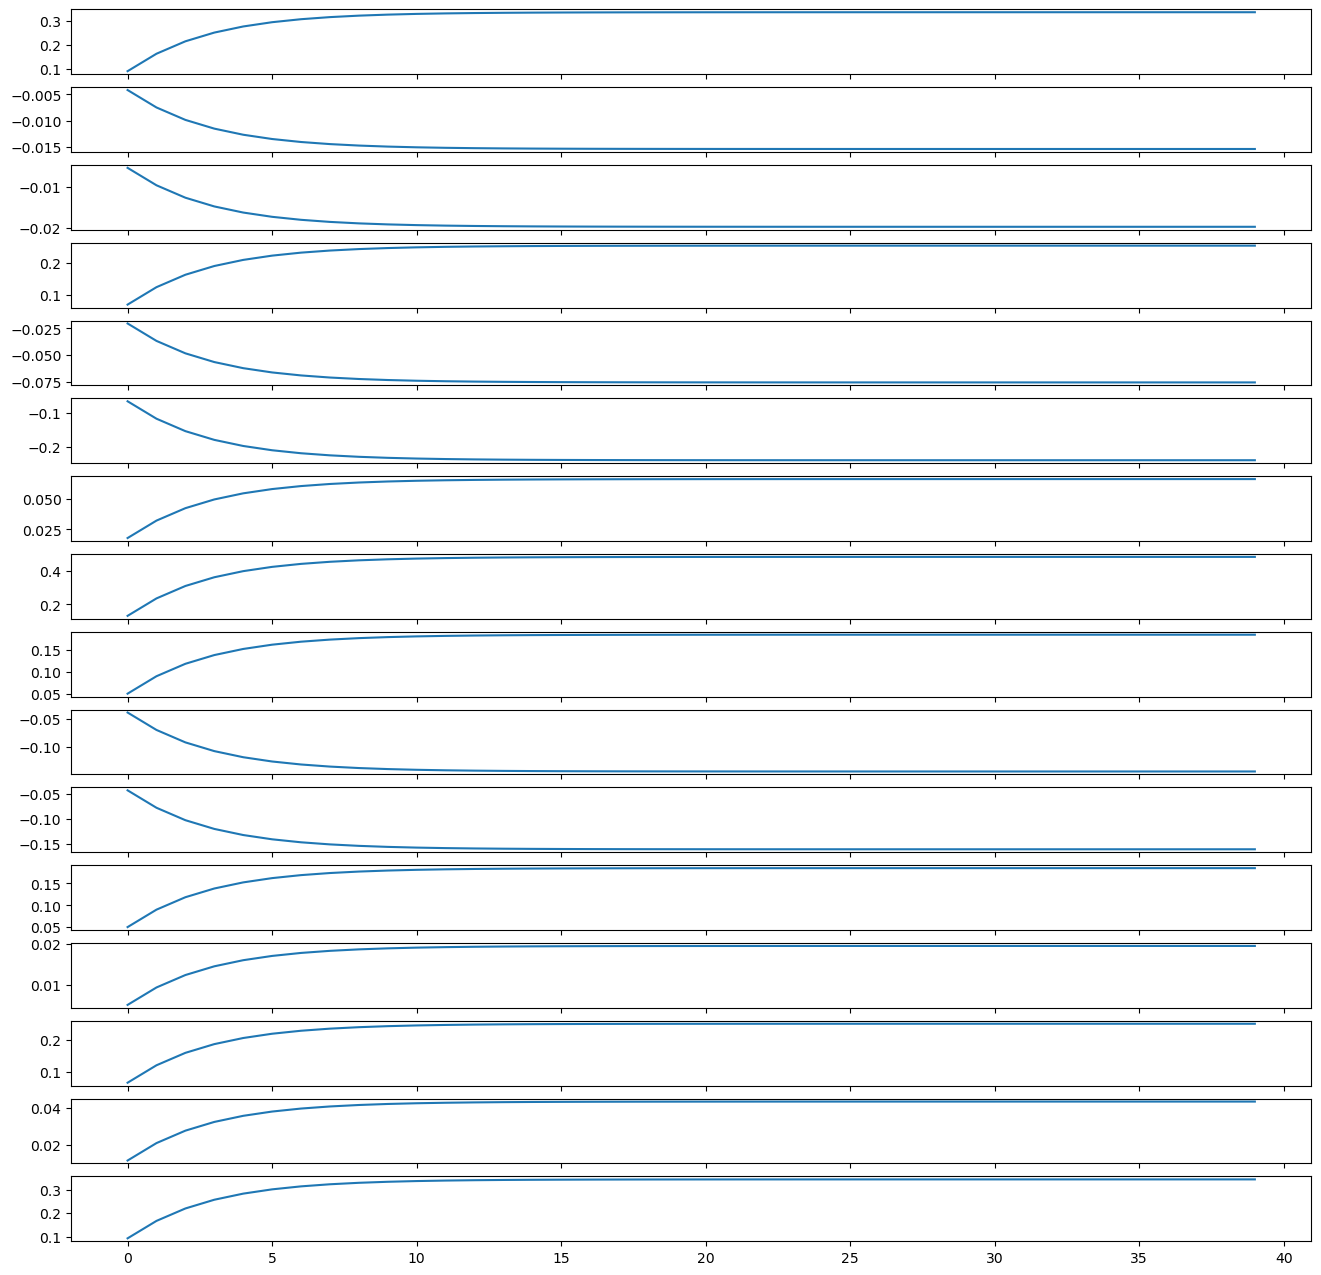


Input: [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Target: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


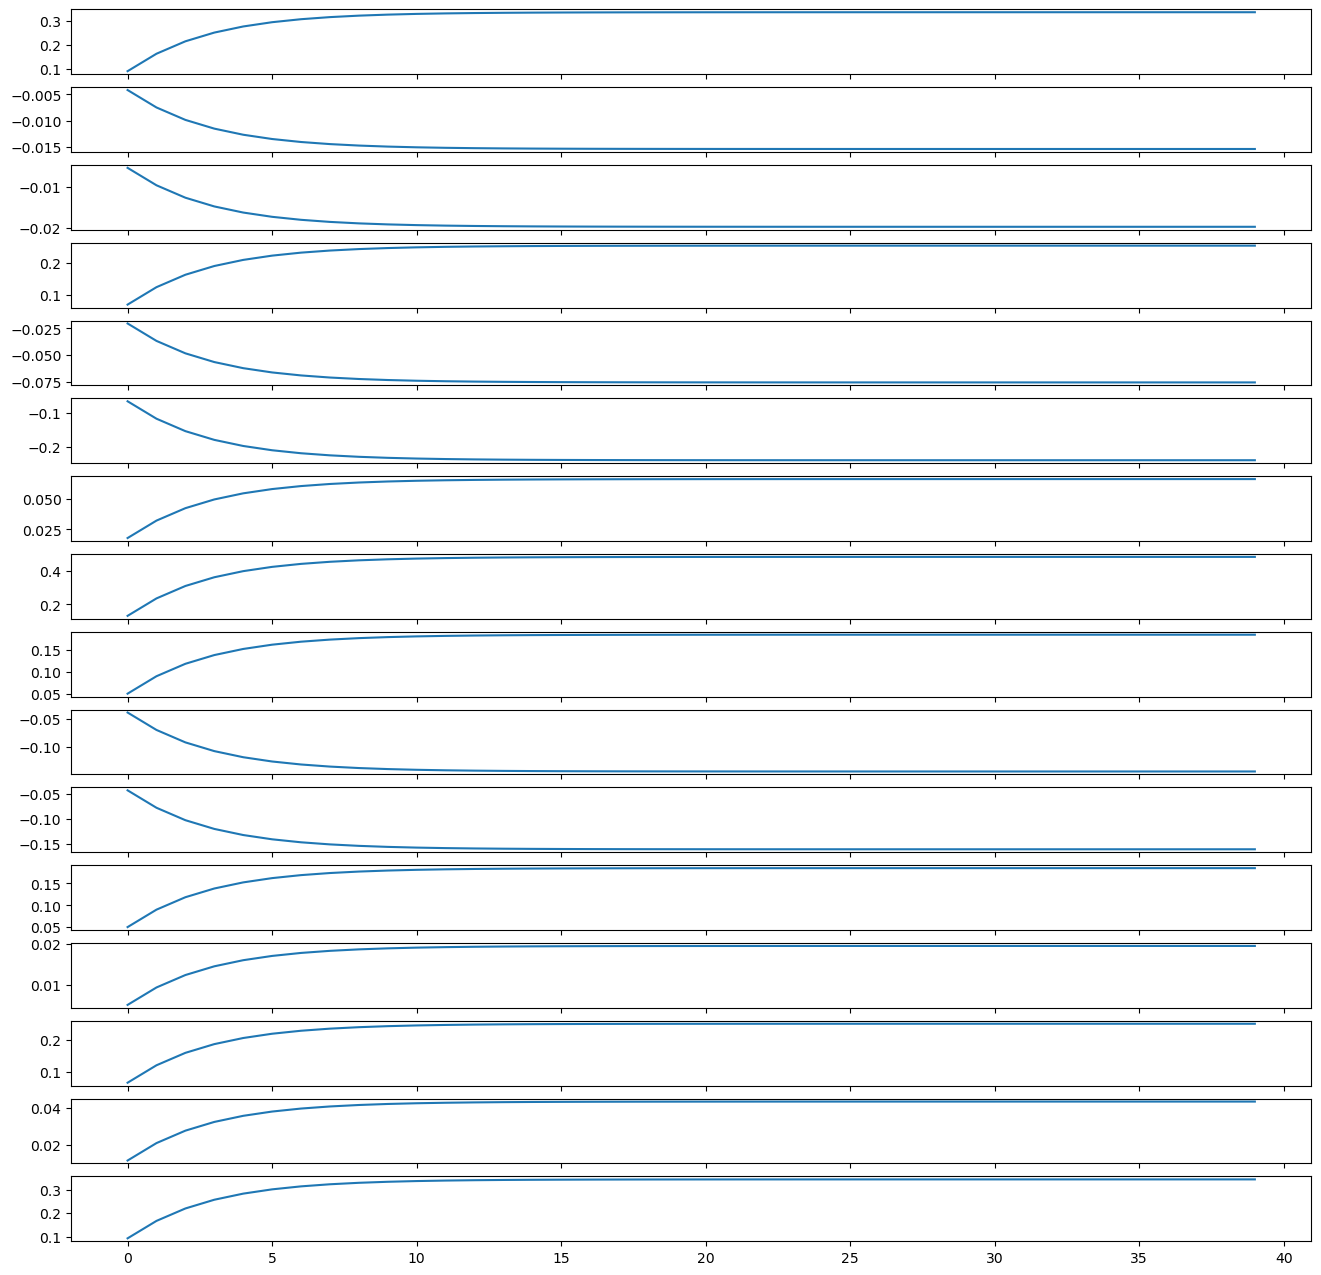

--------------------------

Iteration: 50
Train error: 3.950000047683716
Test error: 3.8249998092651367

Some test examples:

Input: [0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
Target: [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


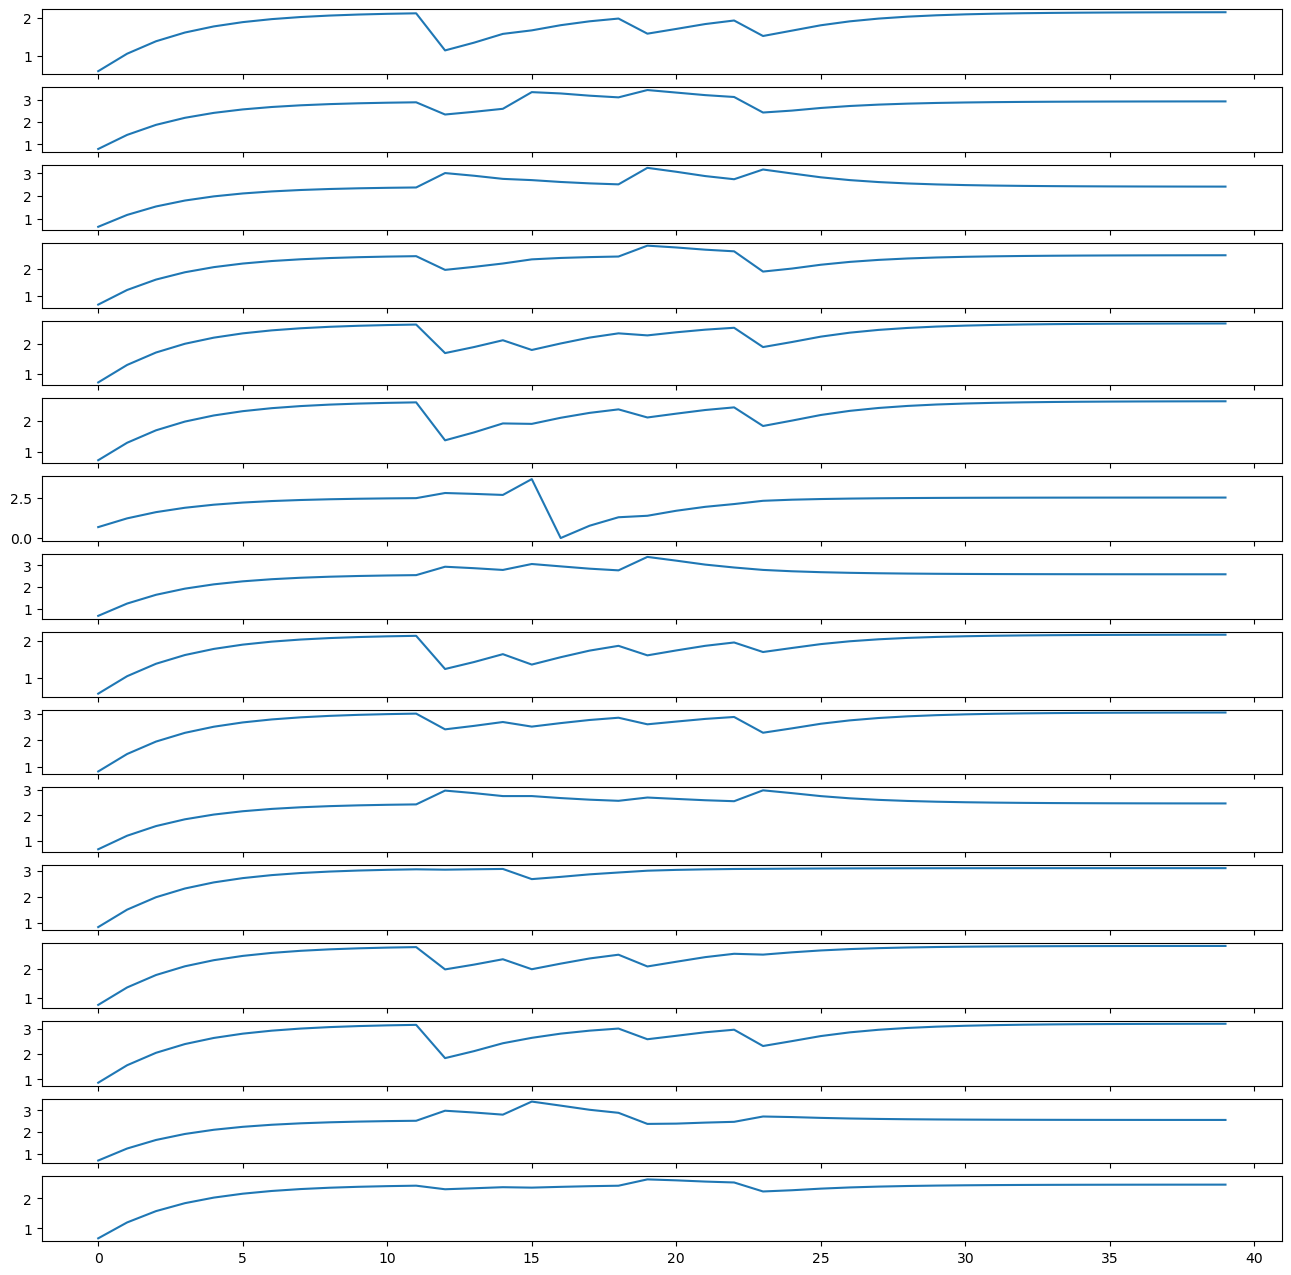


Input: [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Target: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Output: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


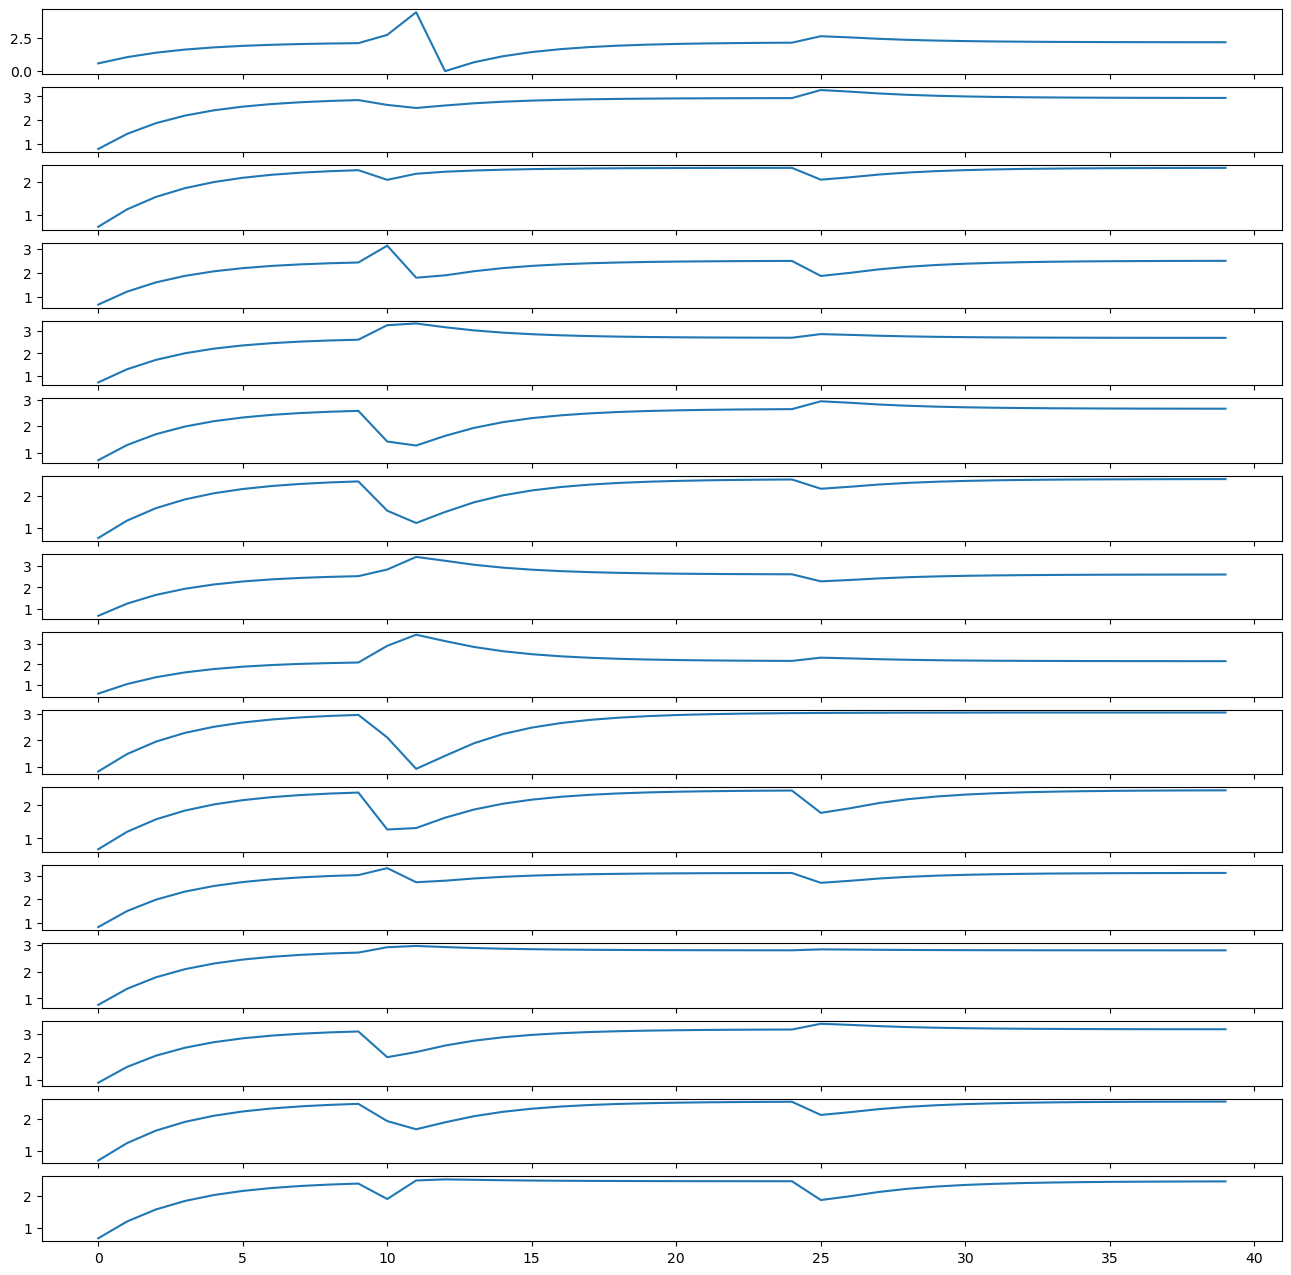


Input: [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
Target: [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
Output: [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]


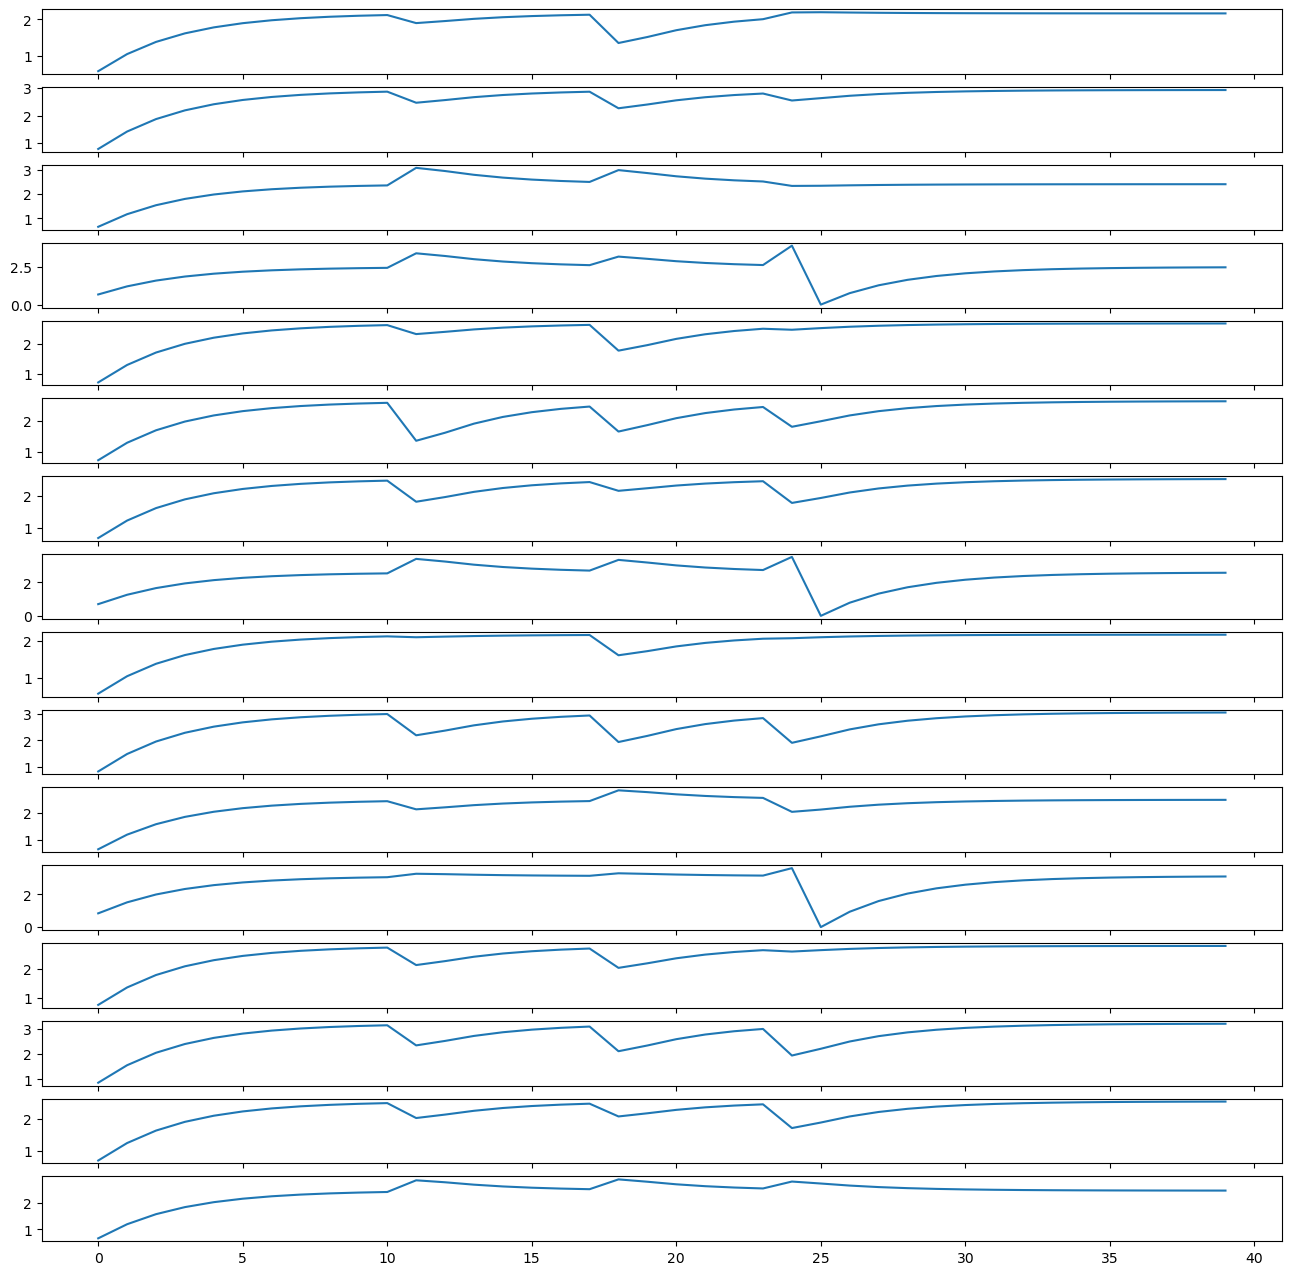


Input: [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0.]
Target: [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
Output: [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


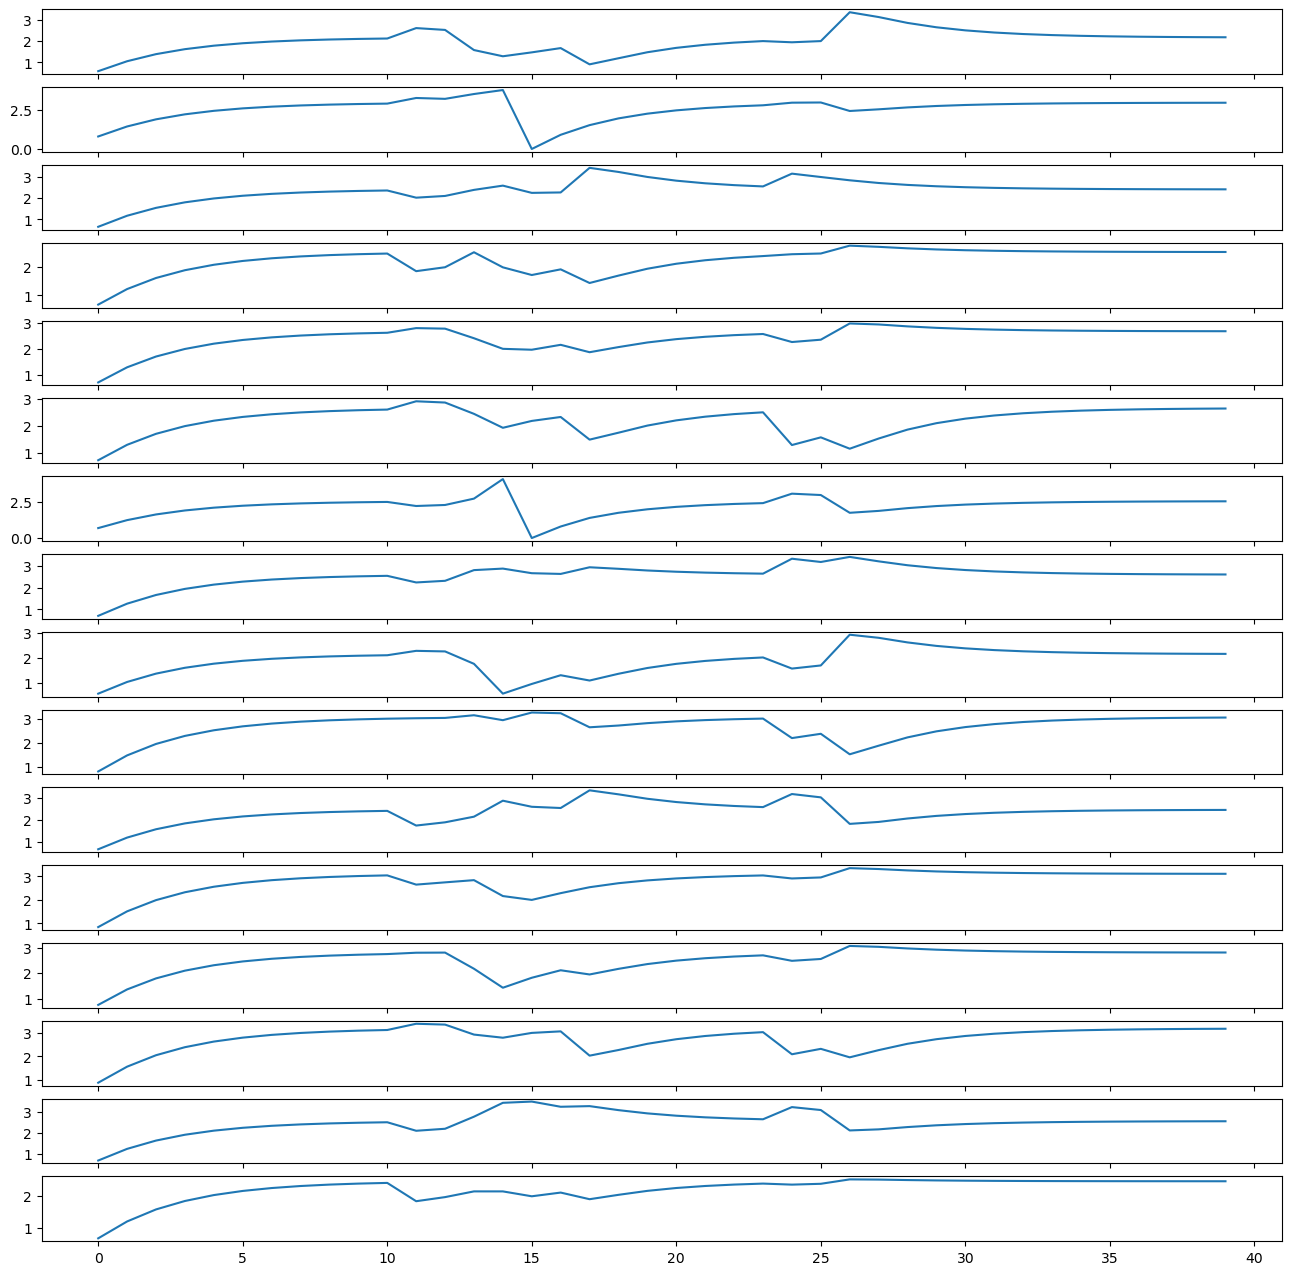


Input: [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Target: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


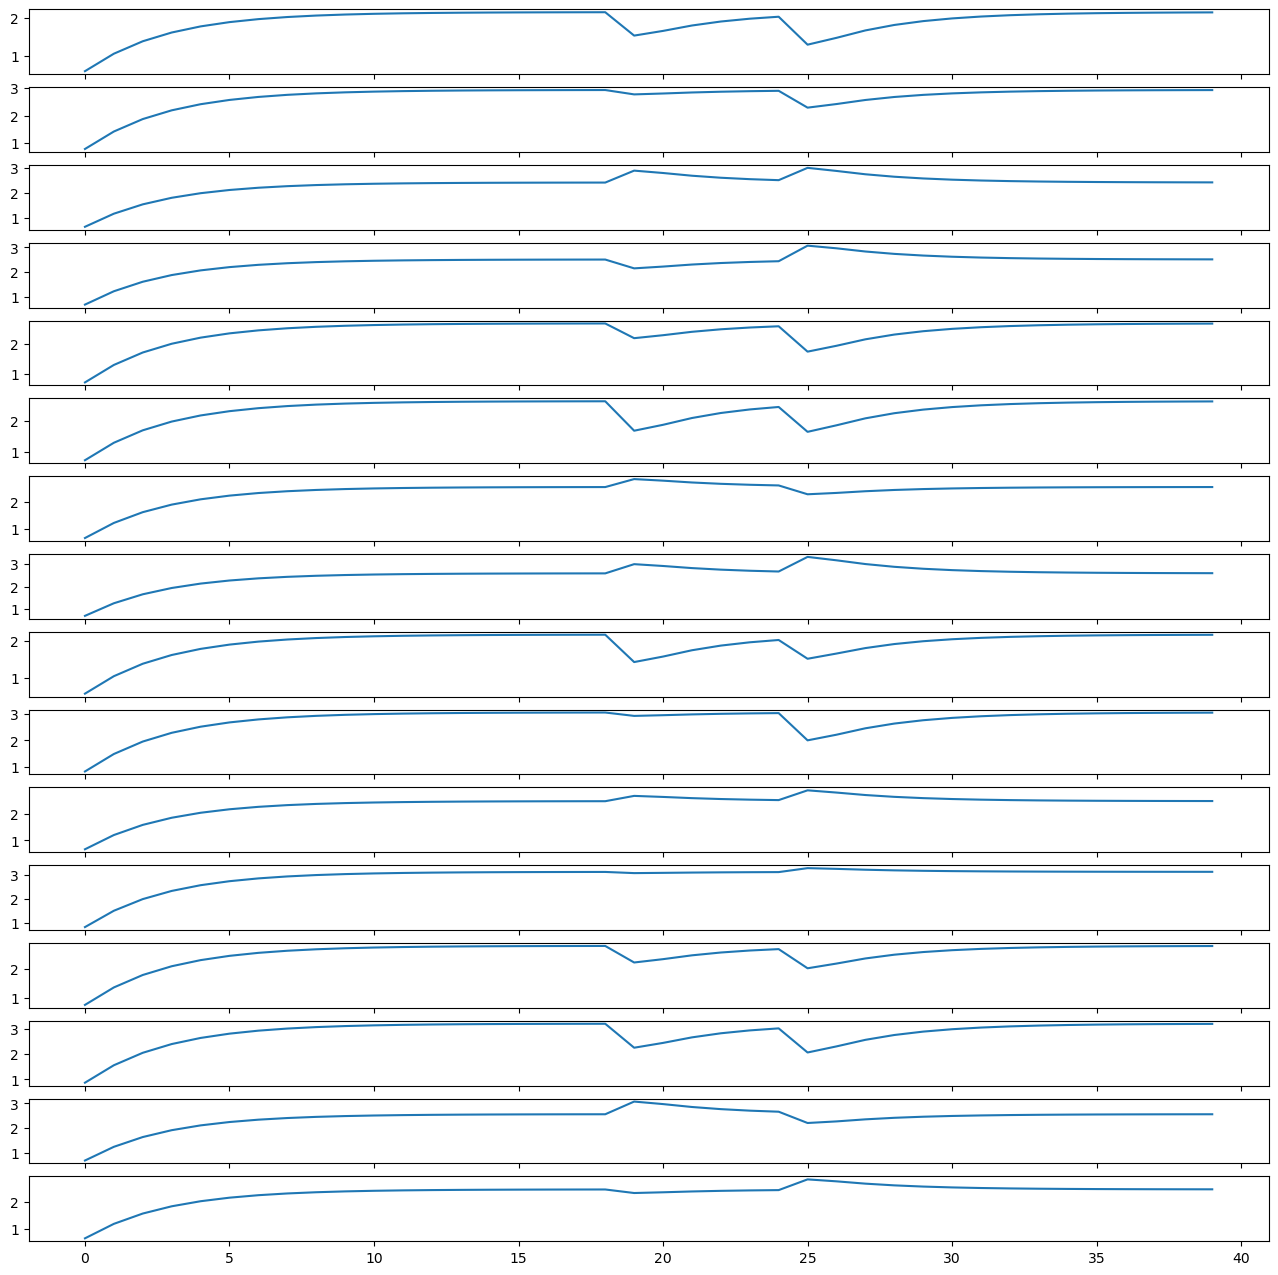

--------------------------

Iteration: 100
Train error: 4.675000190734863
Test error: 4.074999809265137

Some test examples:

Input: [0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
Target: [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Output: [0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.]


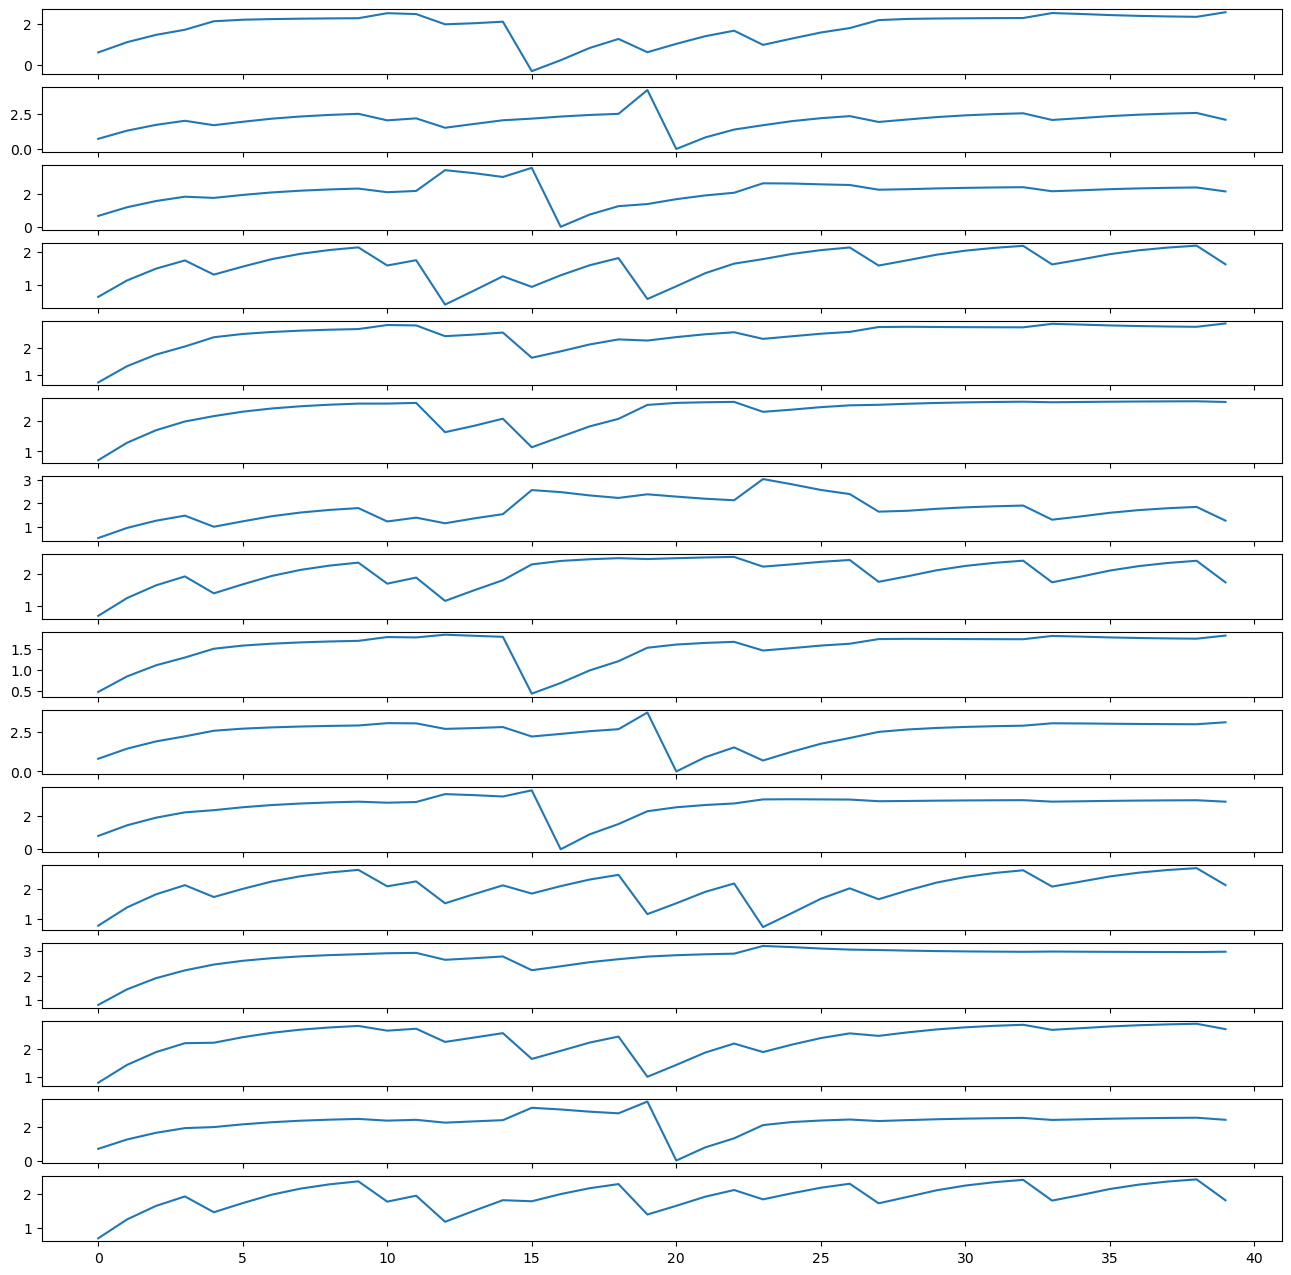


Input: [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Target: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Output: [1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]


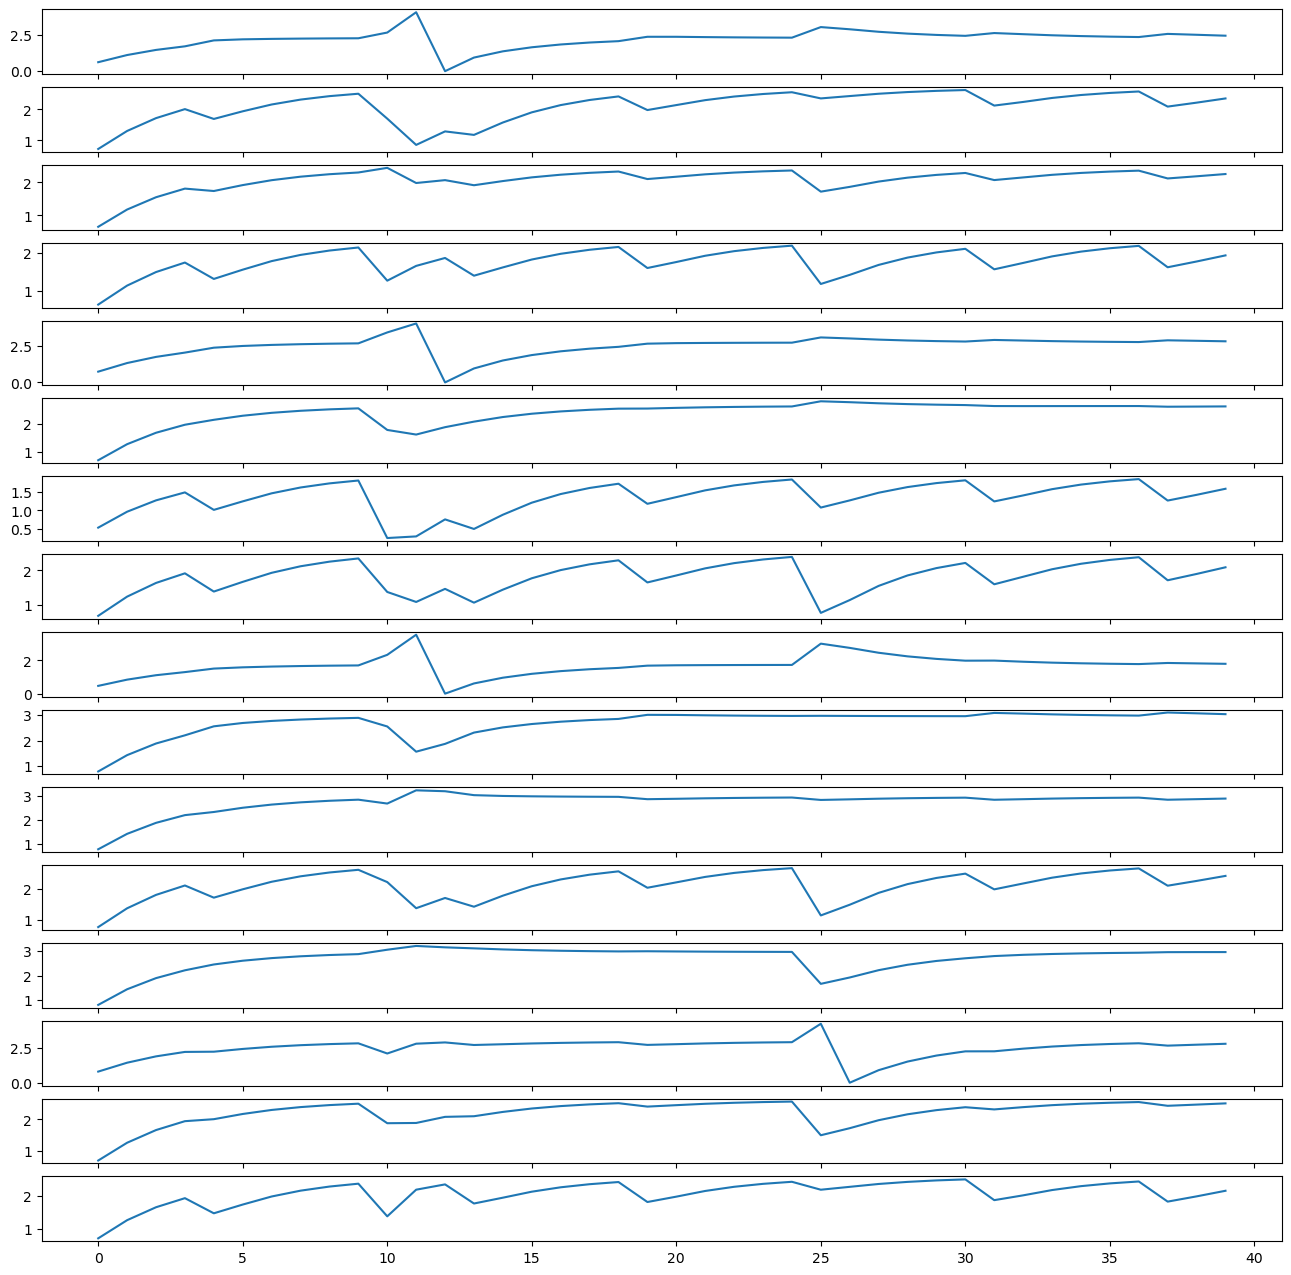


Input: [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
Target: [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


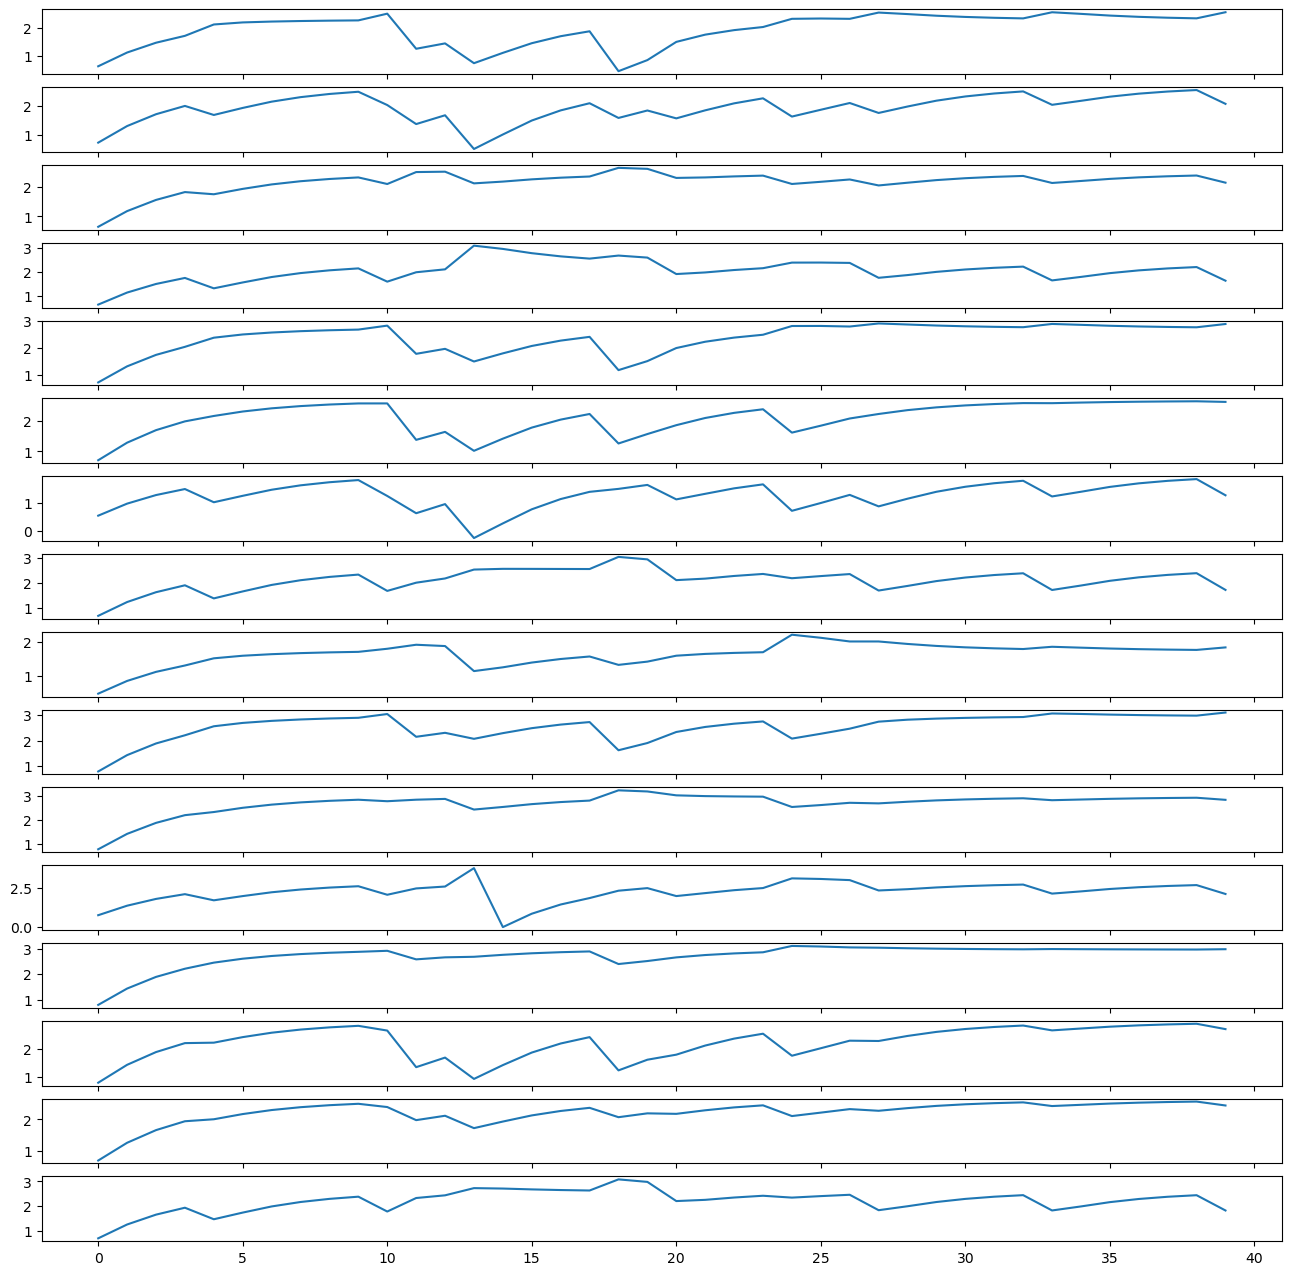


Input: [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0.]
Target: [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
Output: [0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0.]


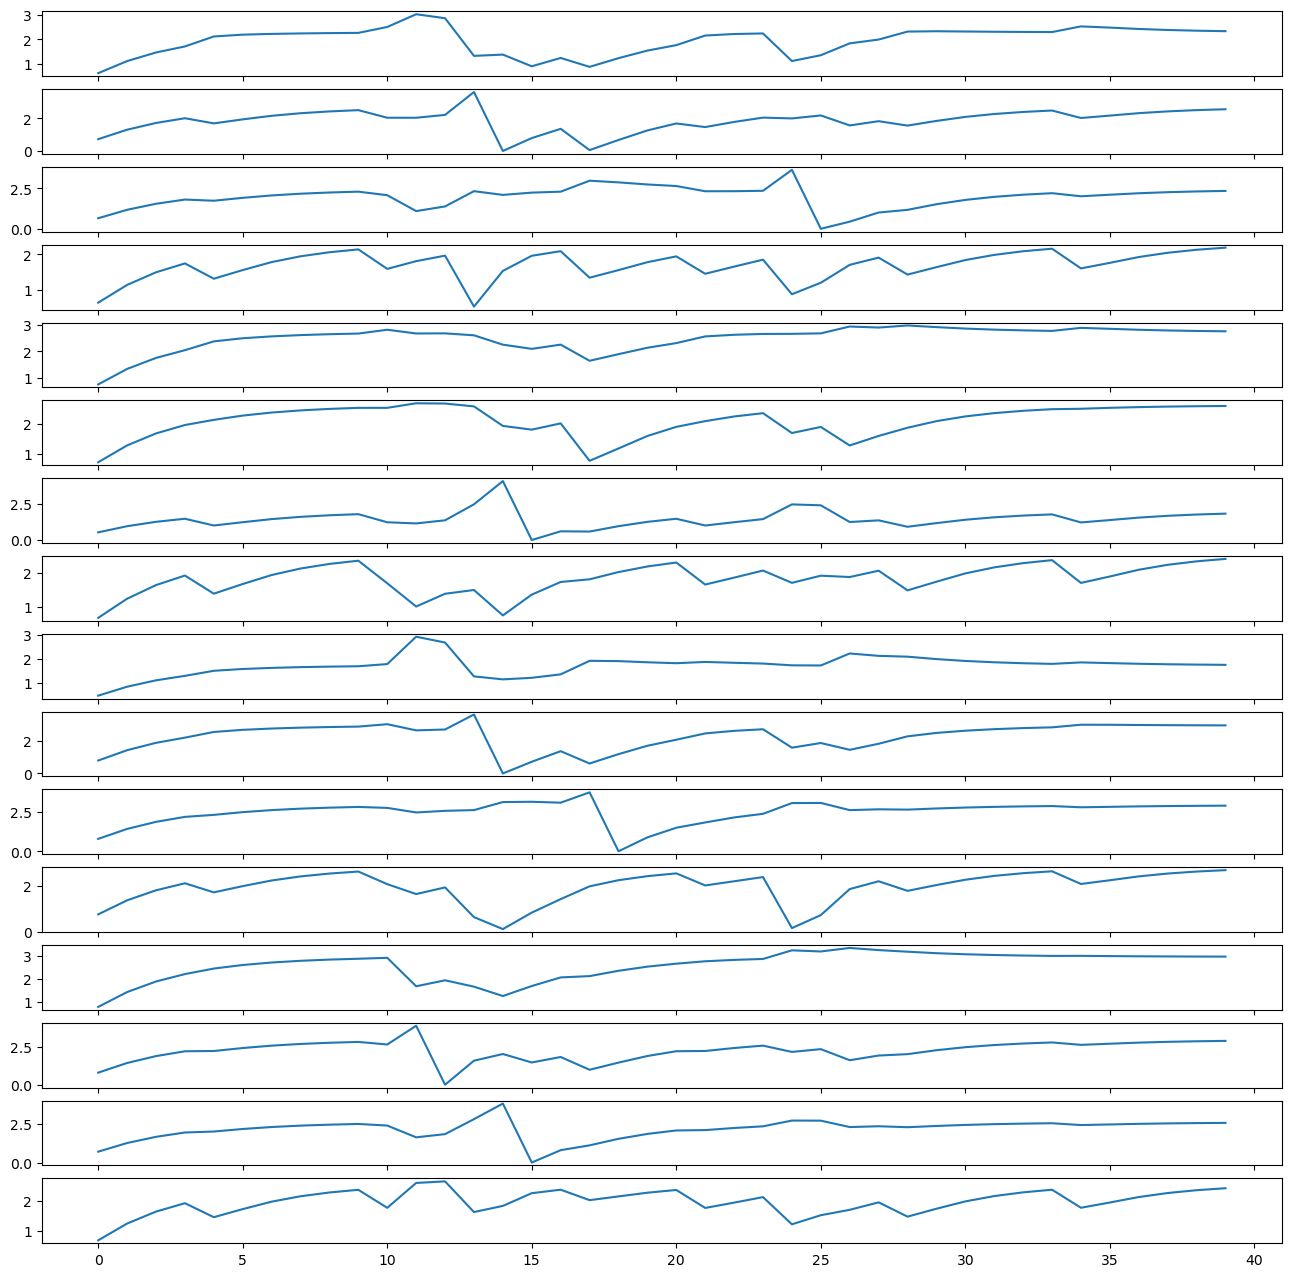


Input: [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Target: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


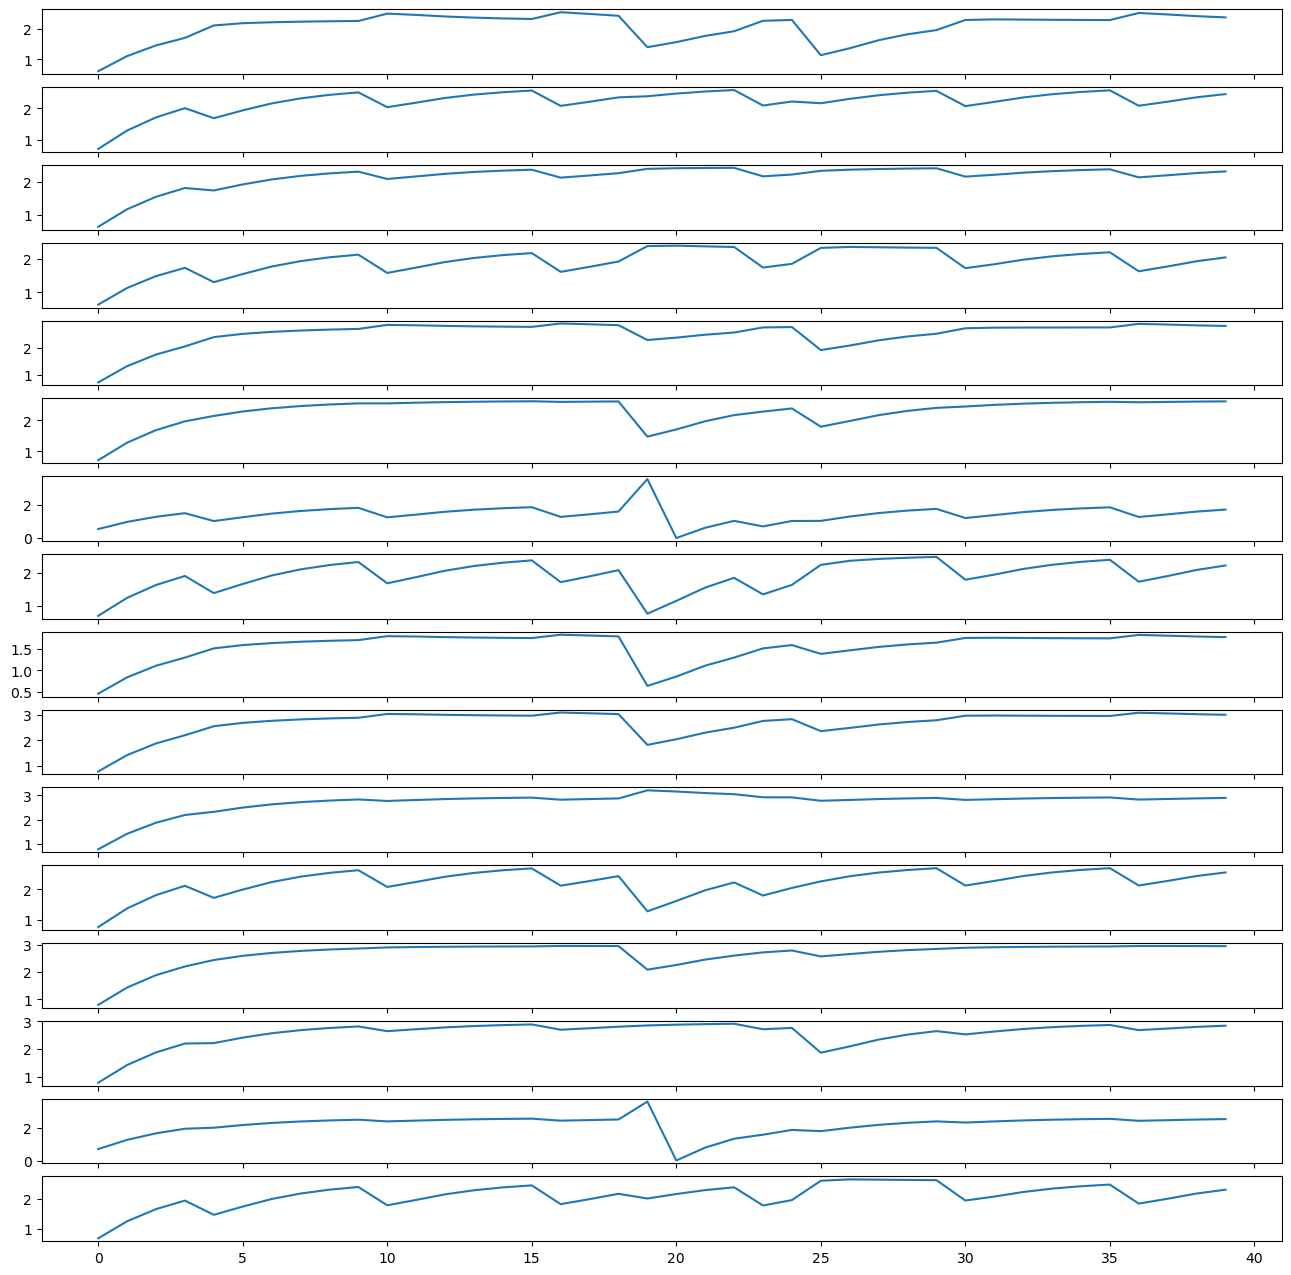

--------------------------

Iteration: 150
Train error: 2.9750001430511475
Test error: 3.424999952316284

Some test examples:

Input: [0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
Target: [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0.]


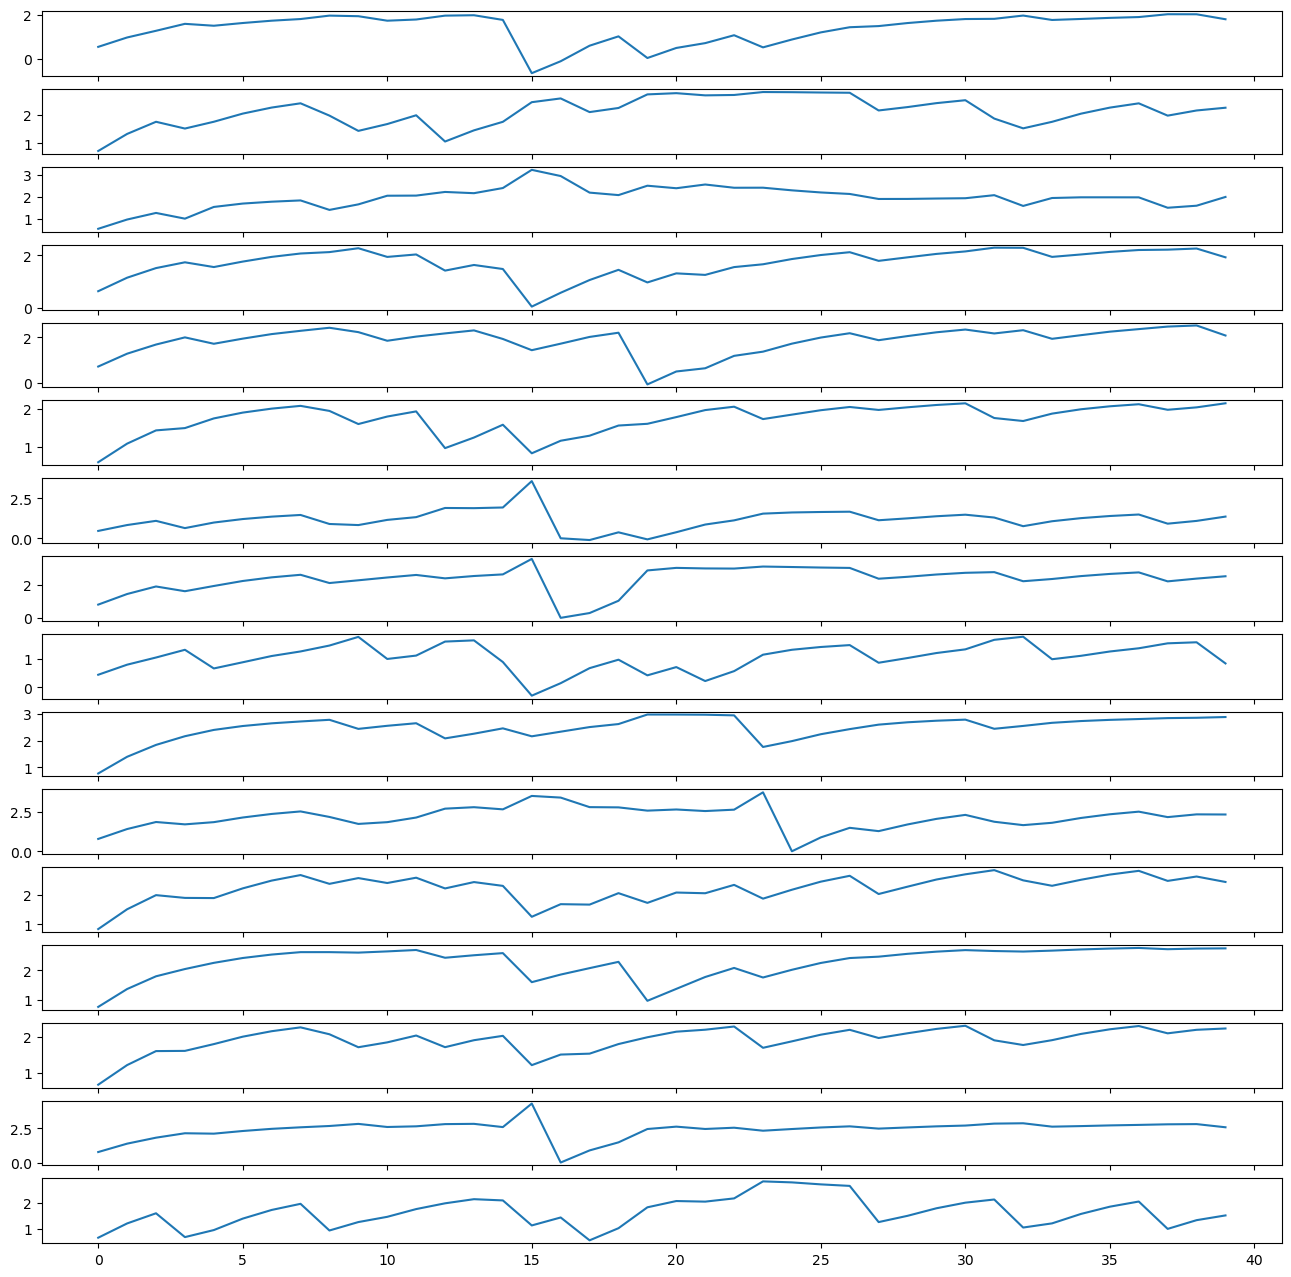


Input: [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Target: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


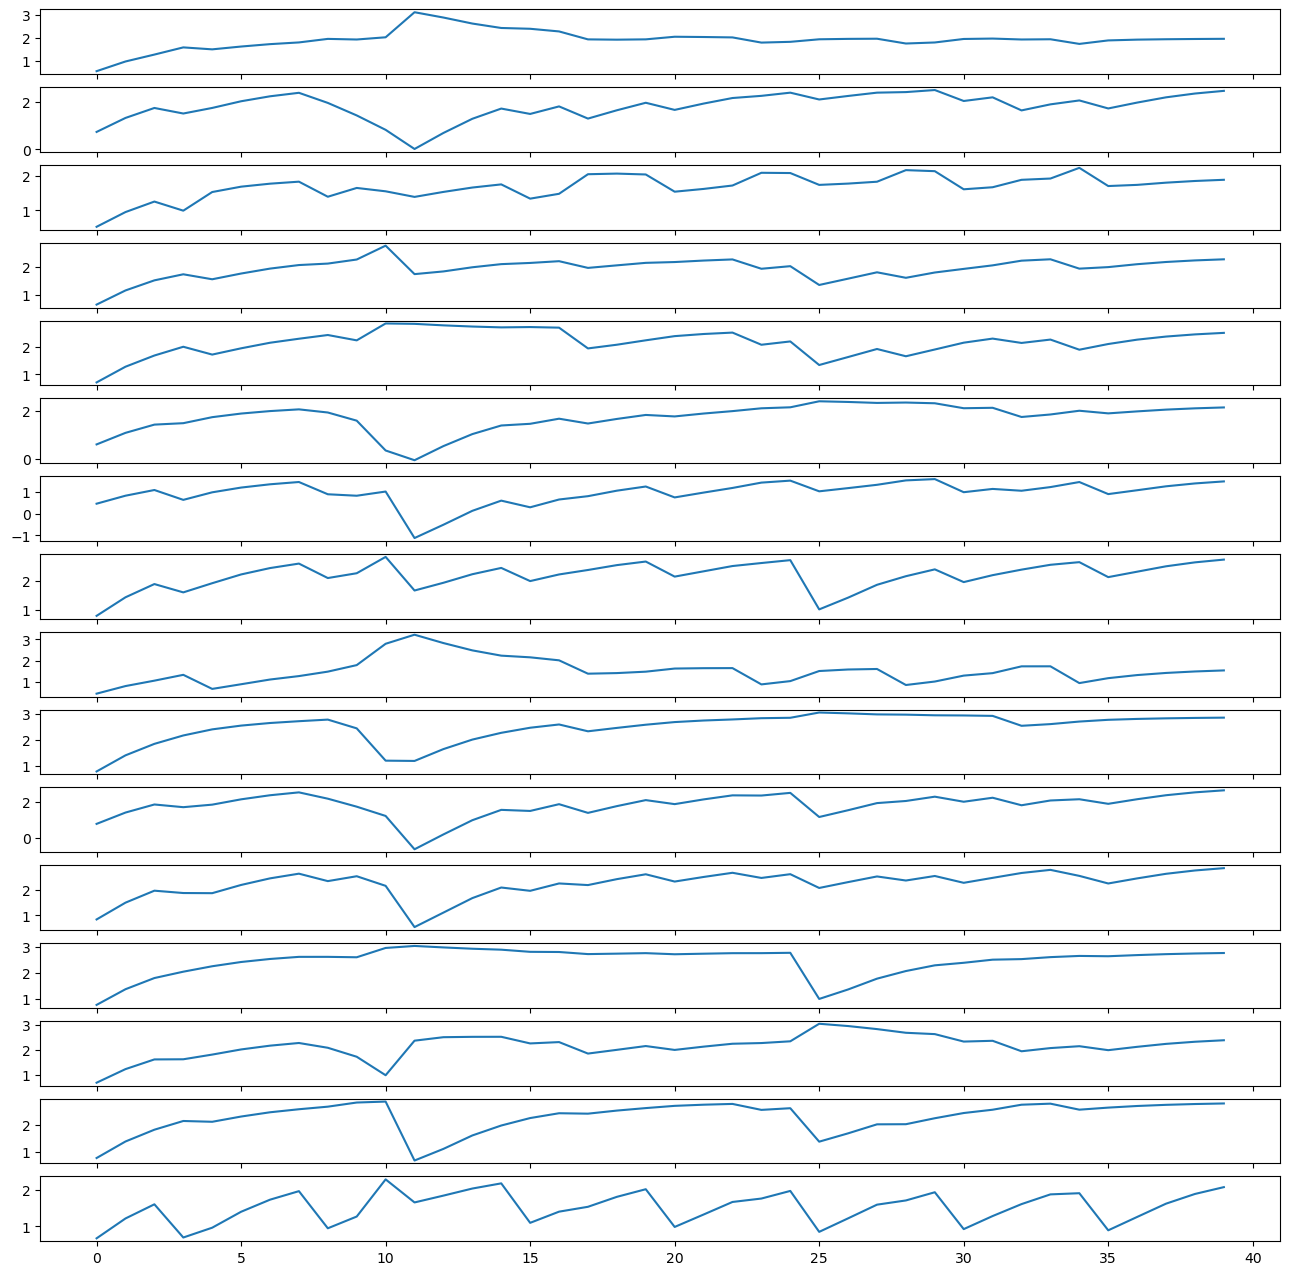


Input: [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
Target: [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
Output: [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


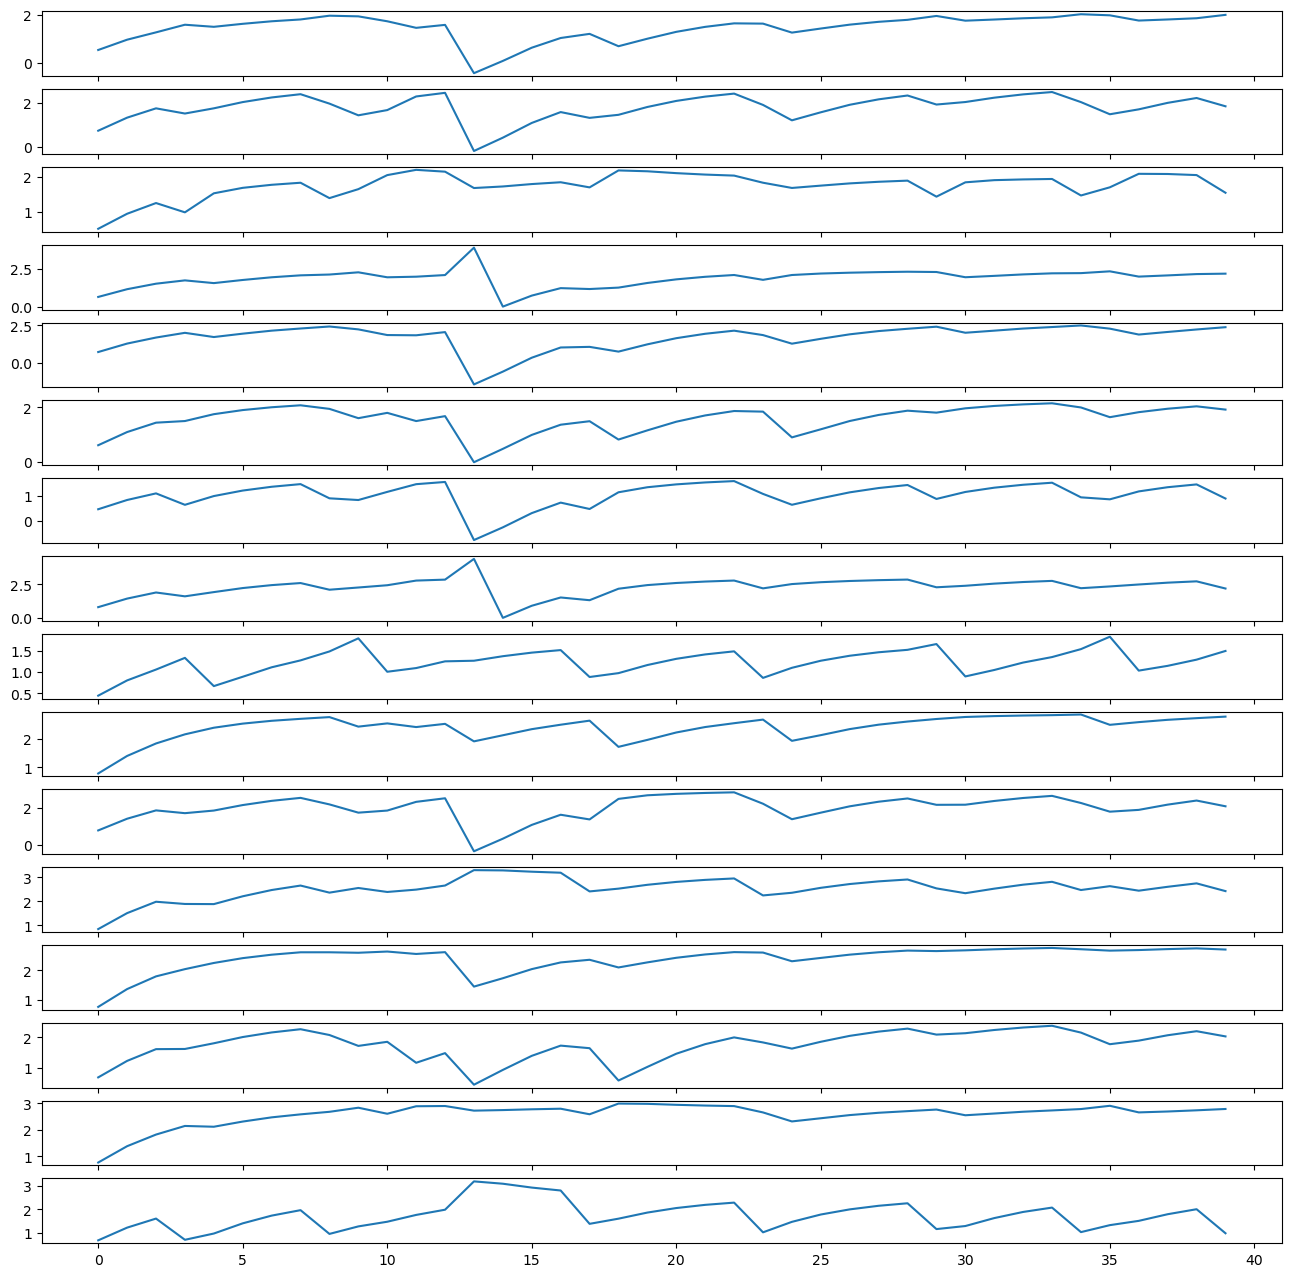


Input: [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0.]
Target: [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
Output: [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.]


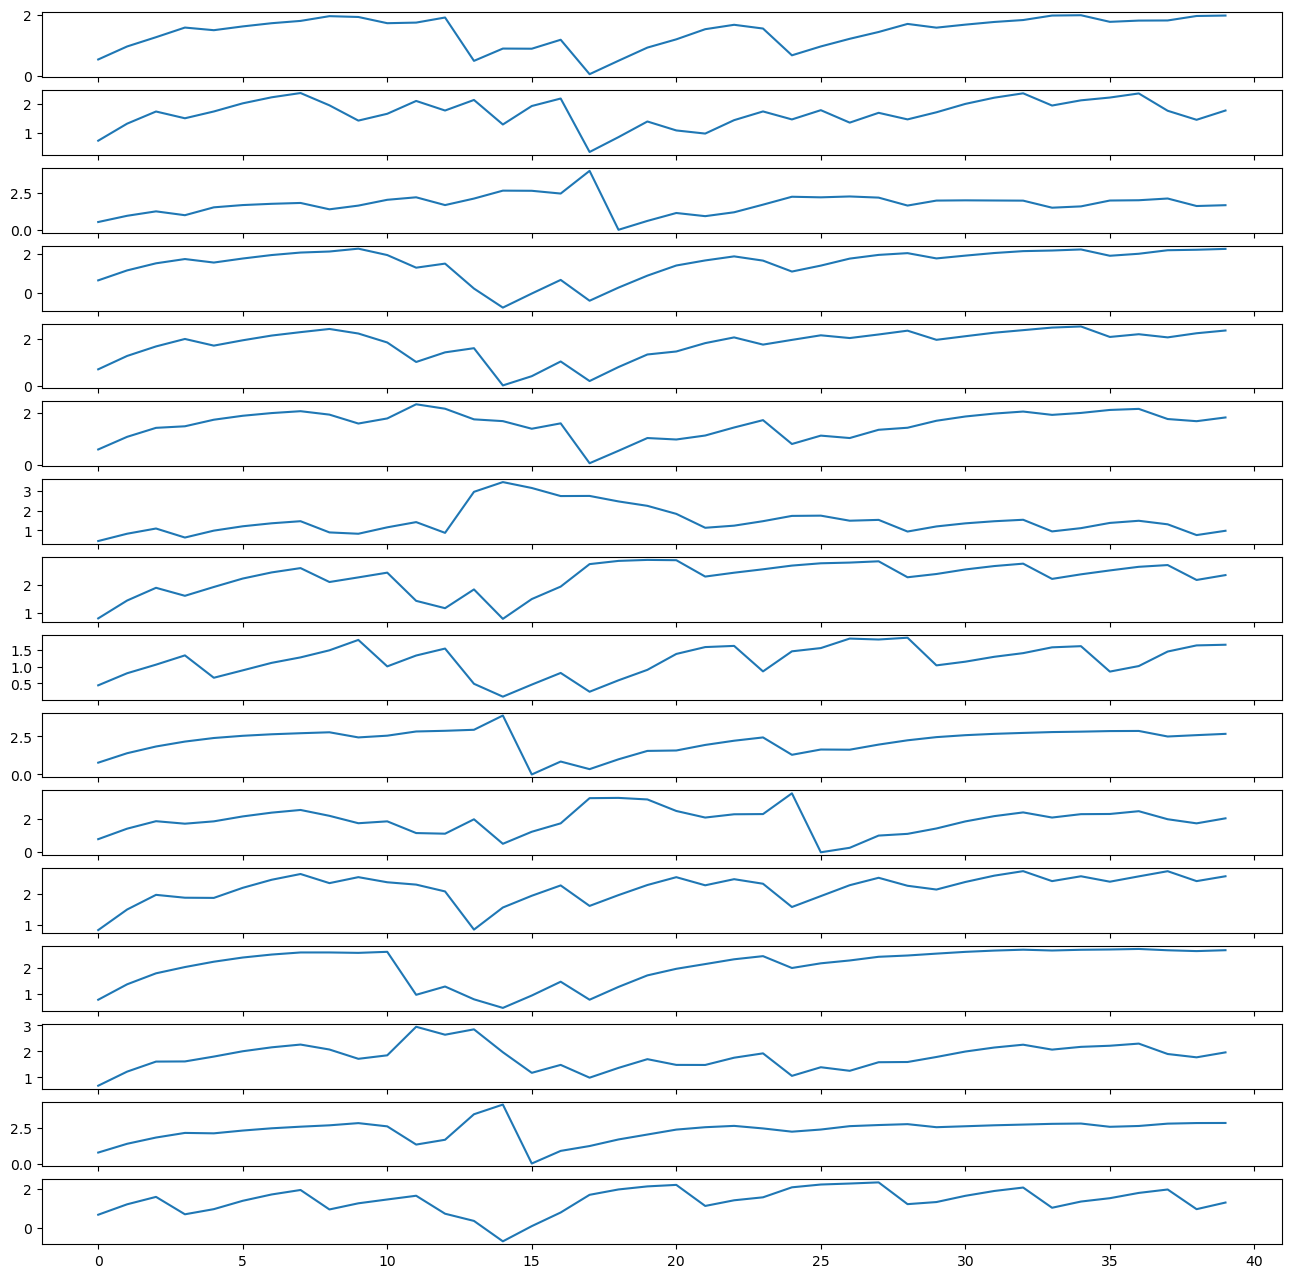


Input: [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Target: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


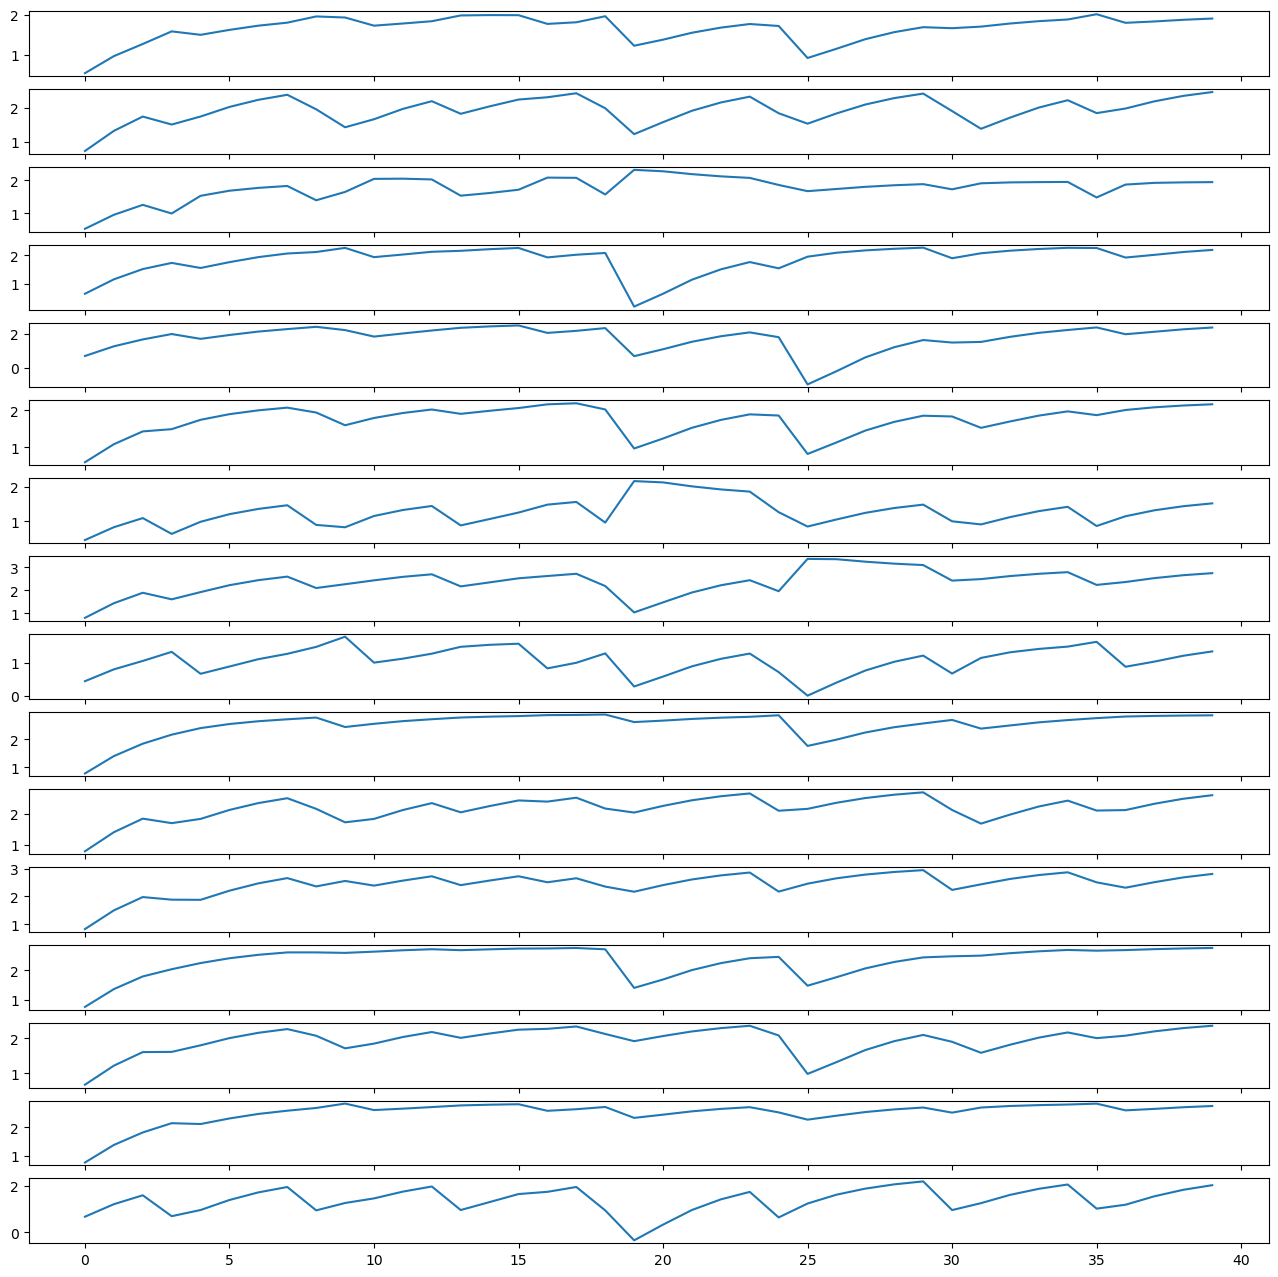

--------------------------

Iteration: 200
Train error: 3.5
Test error: 3.174999952316284

Some test examples:

Input: [0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
Target: [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]


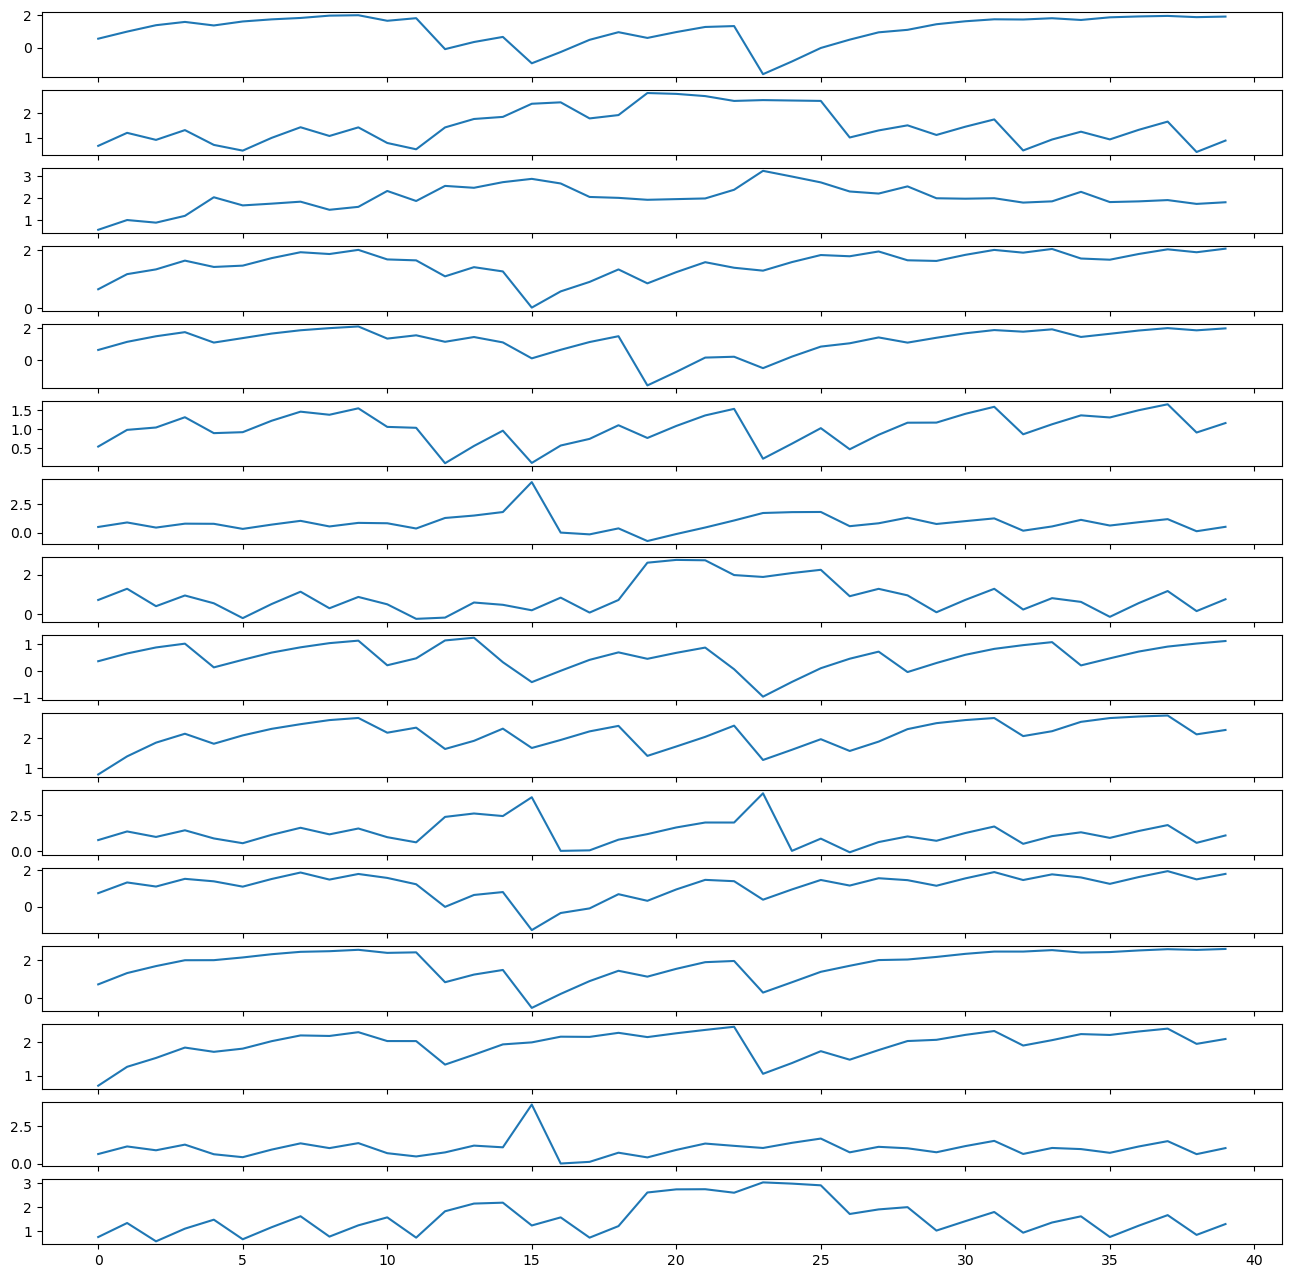


Input: [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Target: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Output: [1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.]


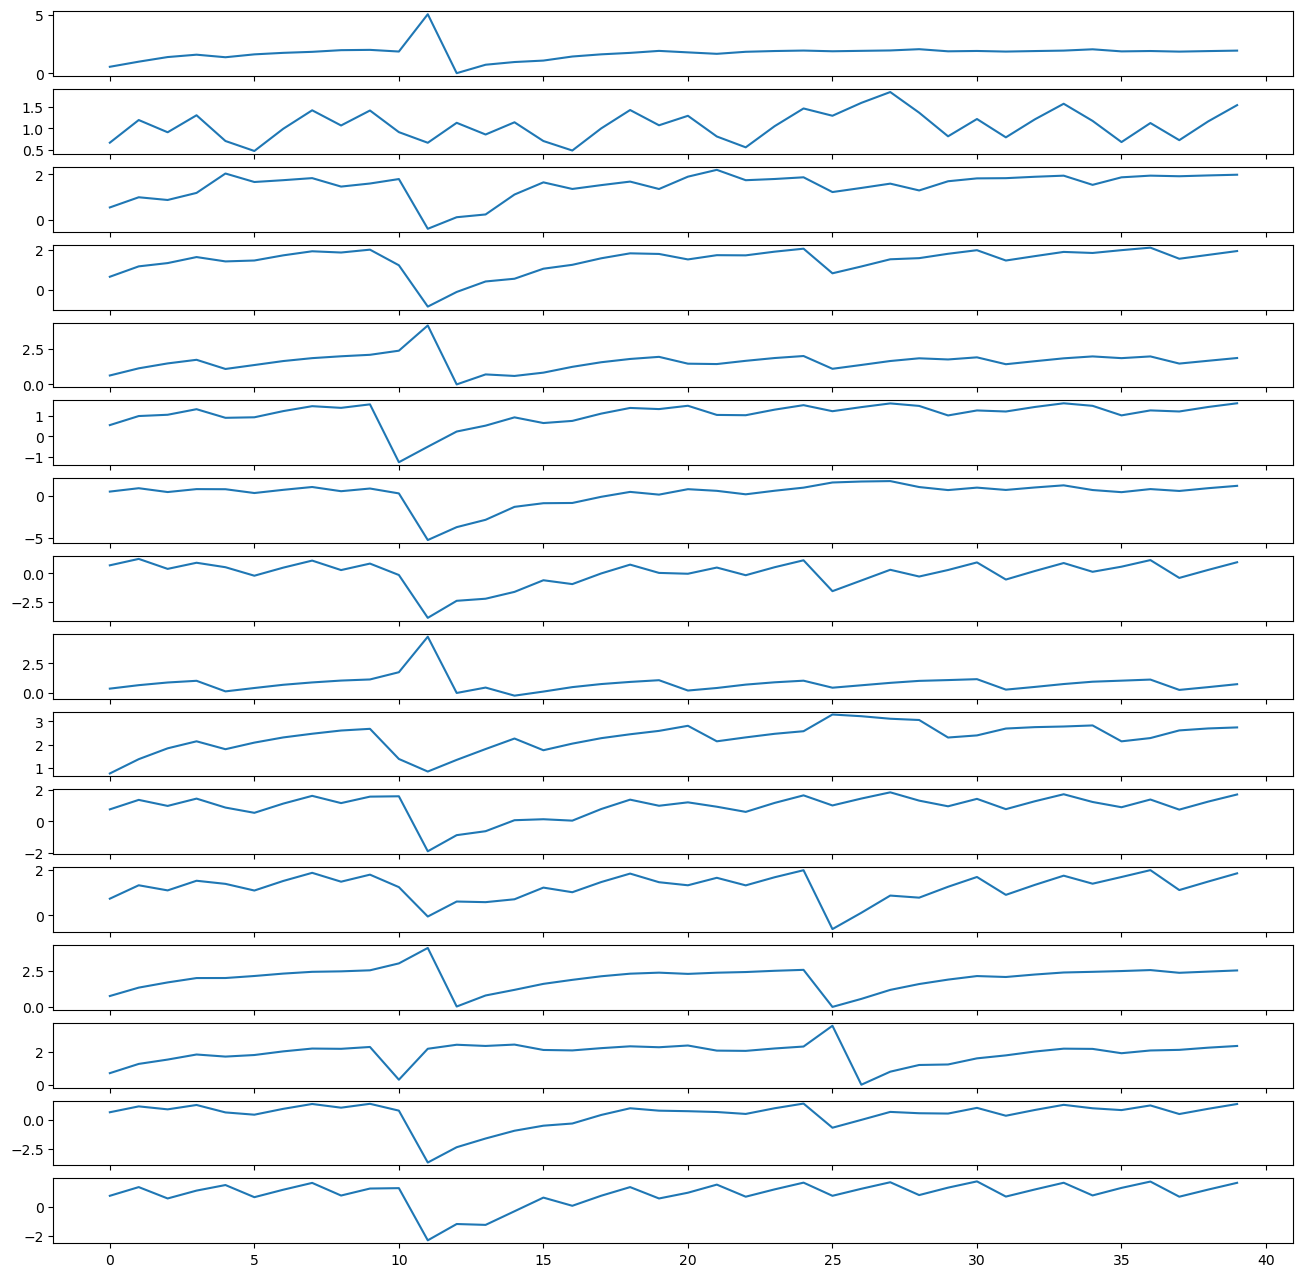


Input: [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
Target: [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
Output: [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]


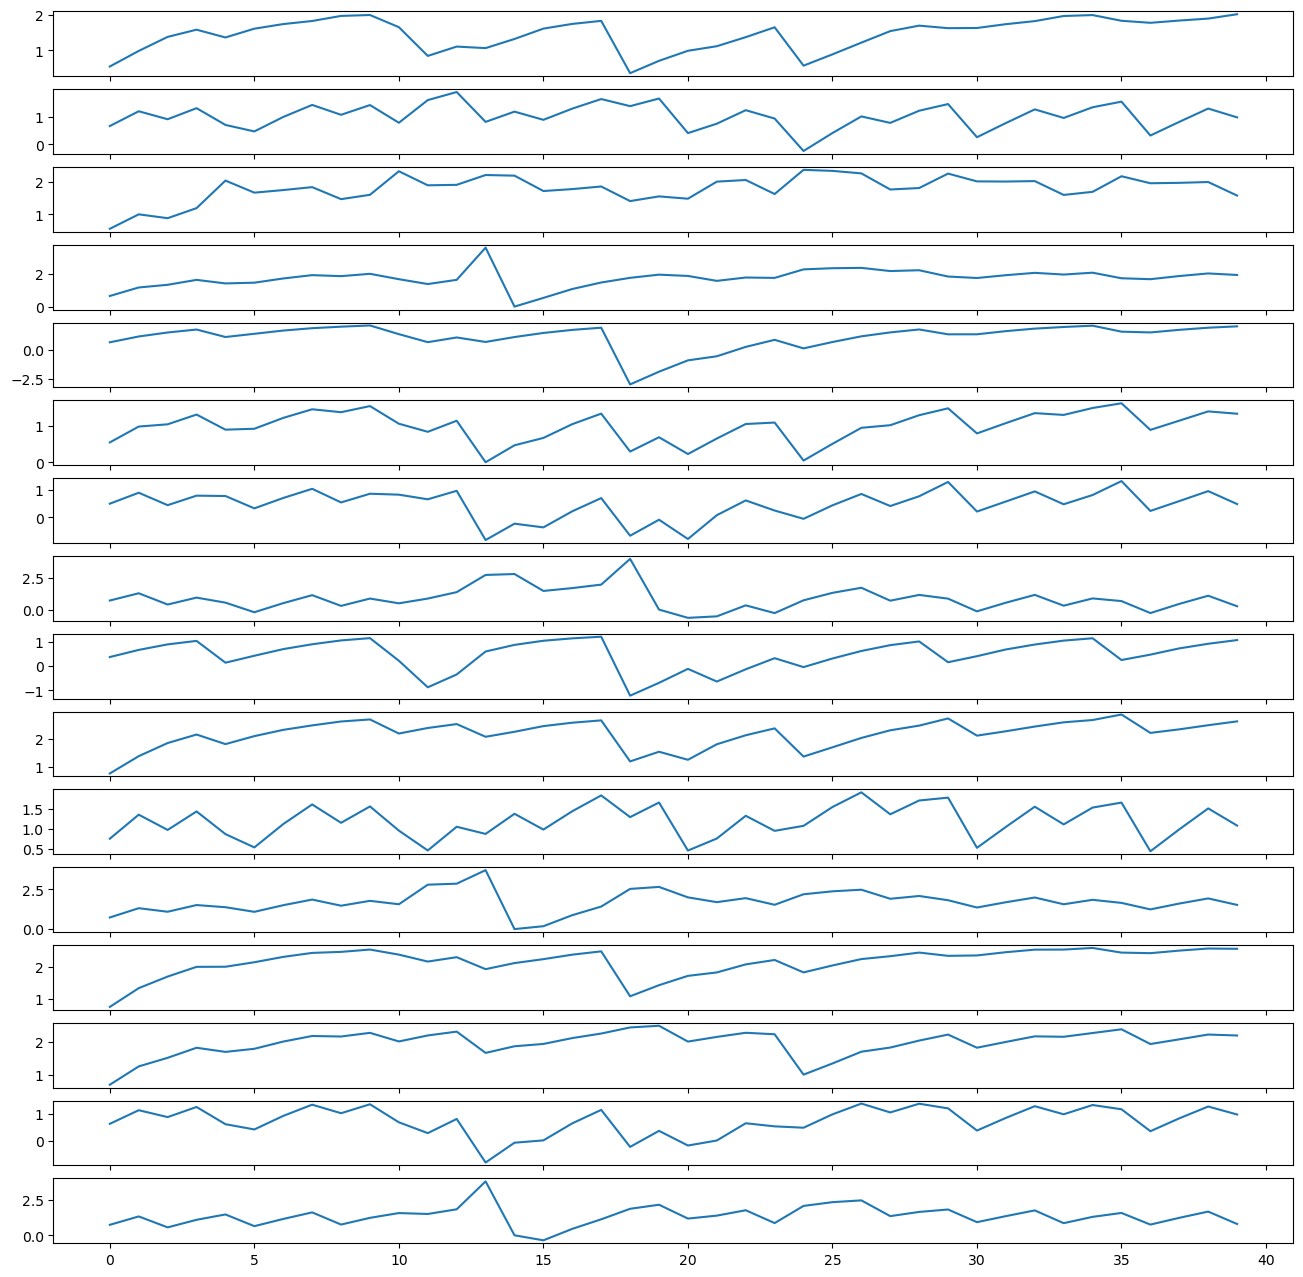


Input: [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0.]
Target: [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
Output: [0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.]


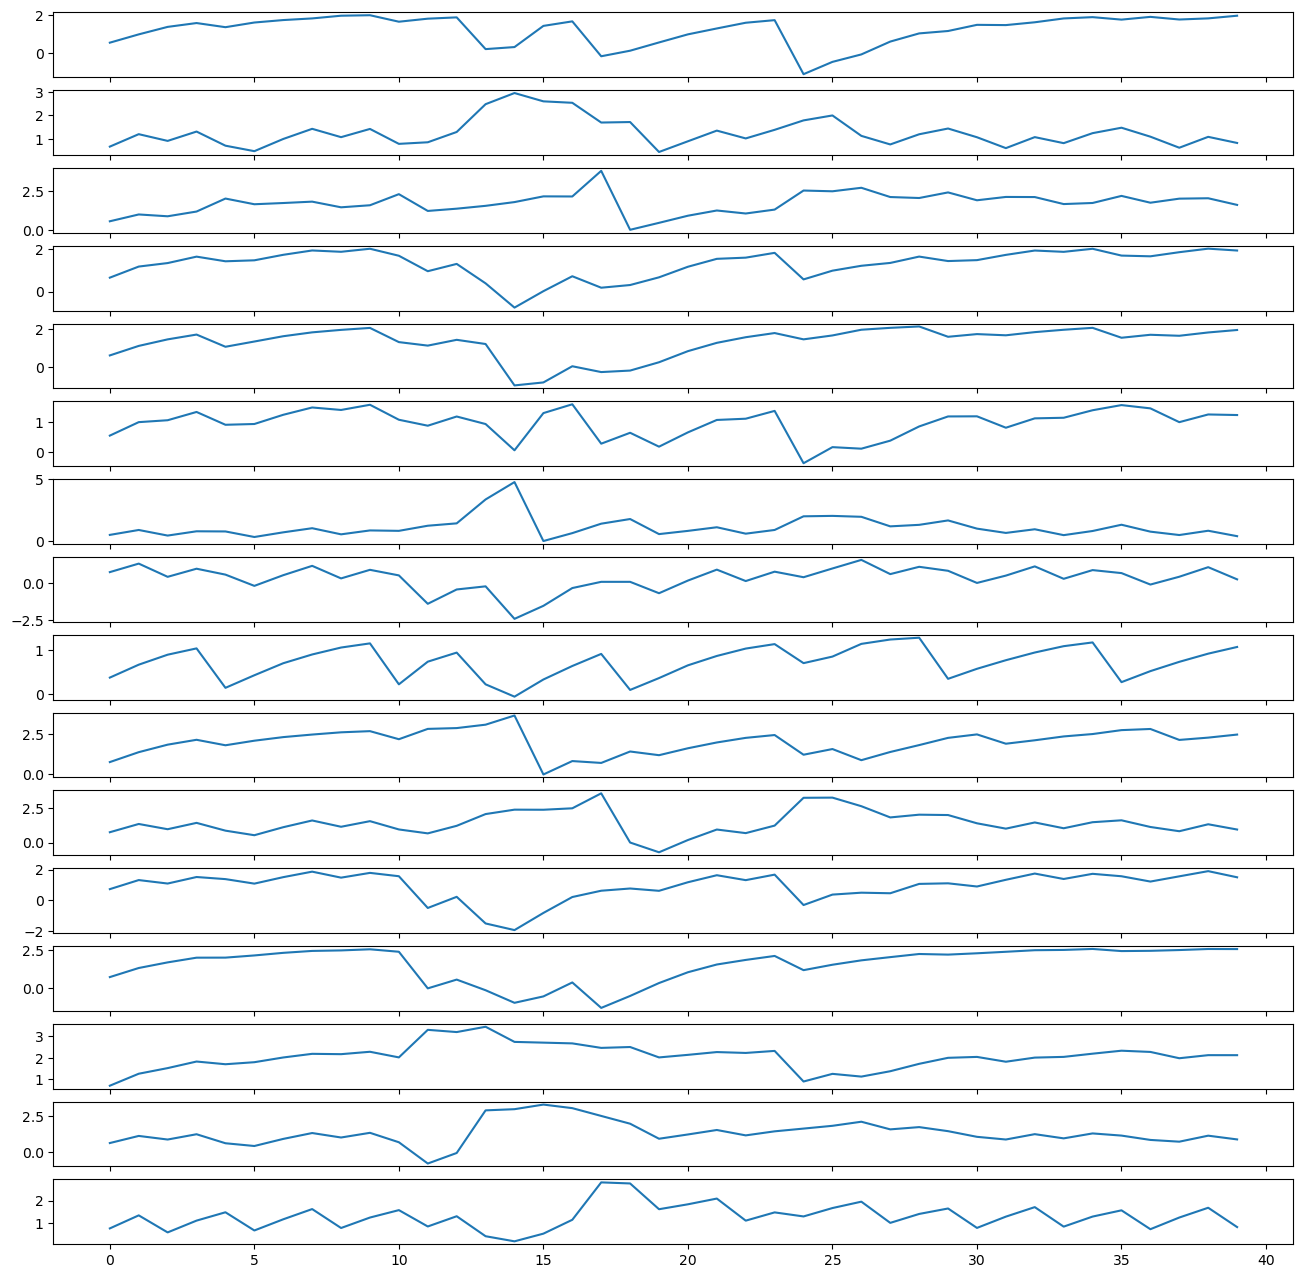


Input: [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Target: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


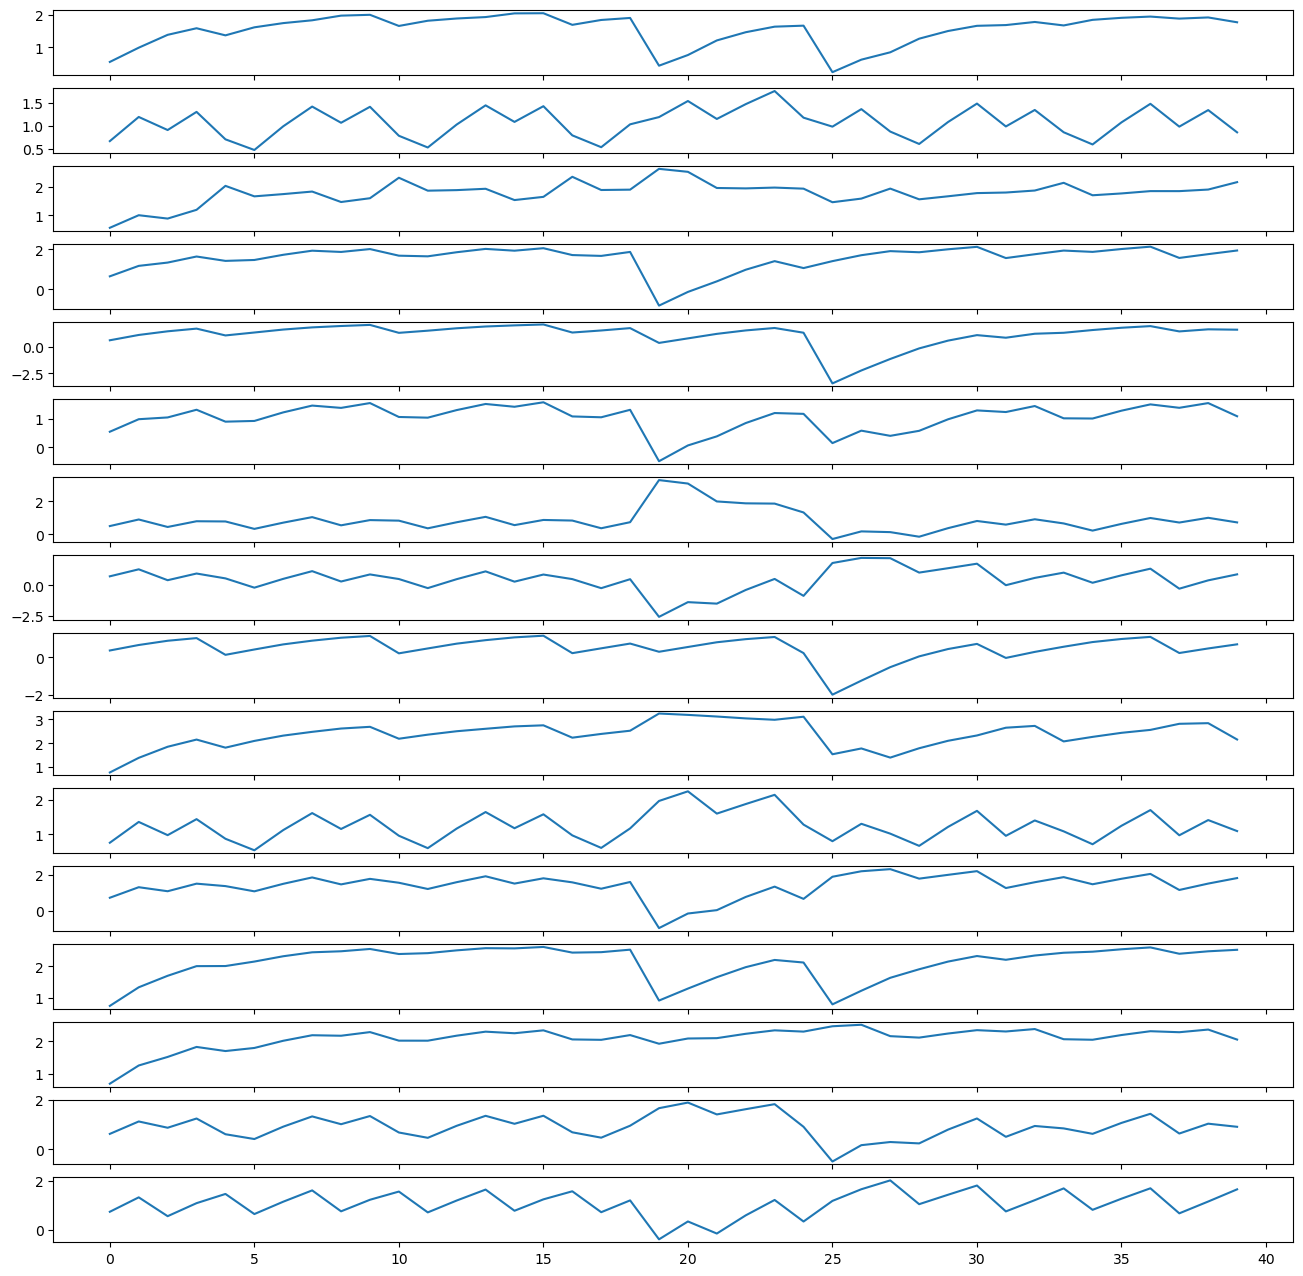

--------------------------

Iteration: 250
Train error: 2.7250001430511475
Test error: 3.450000047683716

Some test examples:

Input: [0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
Target: [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


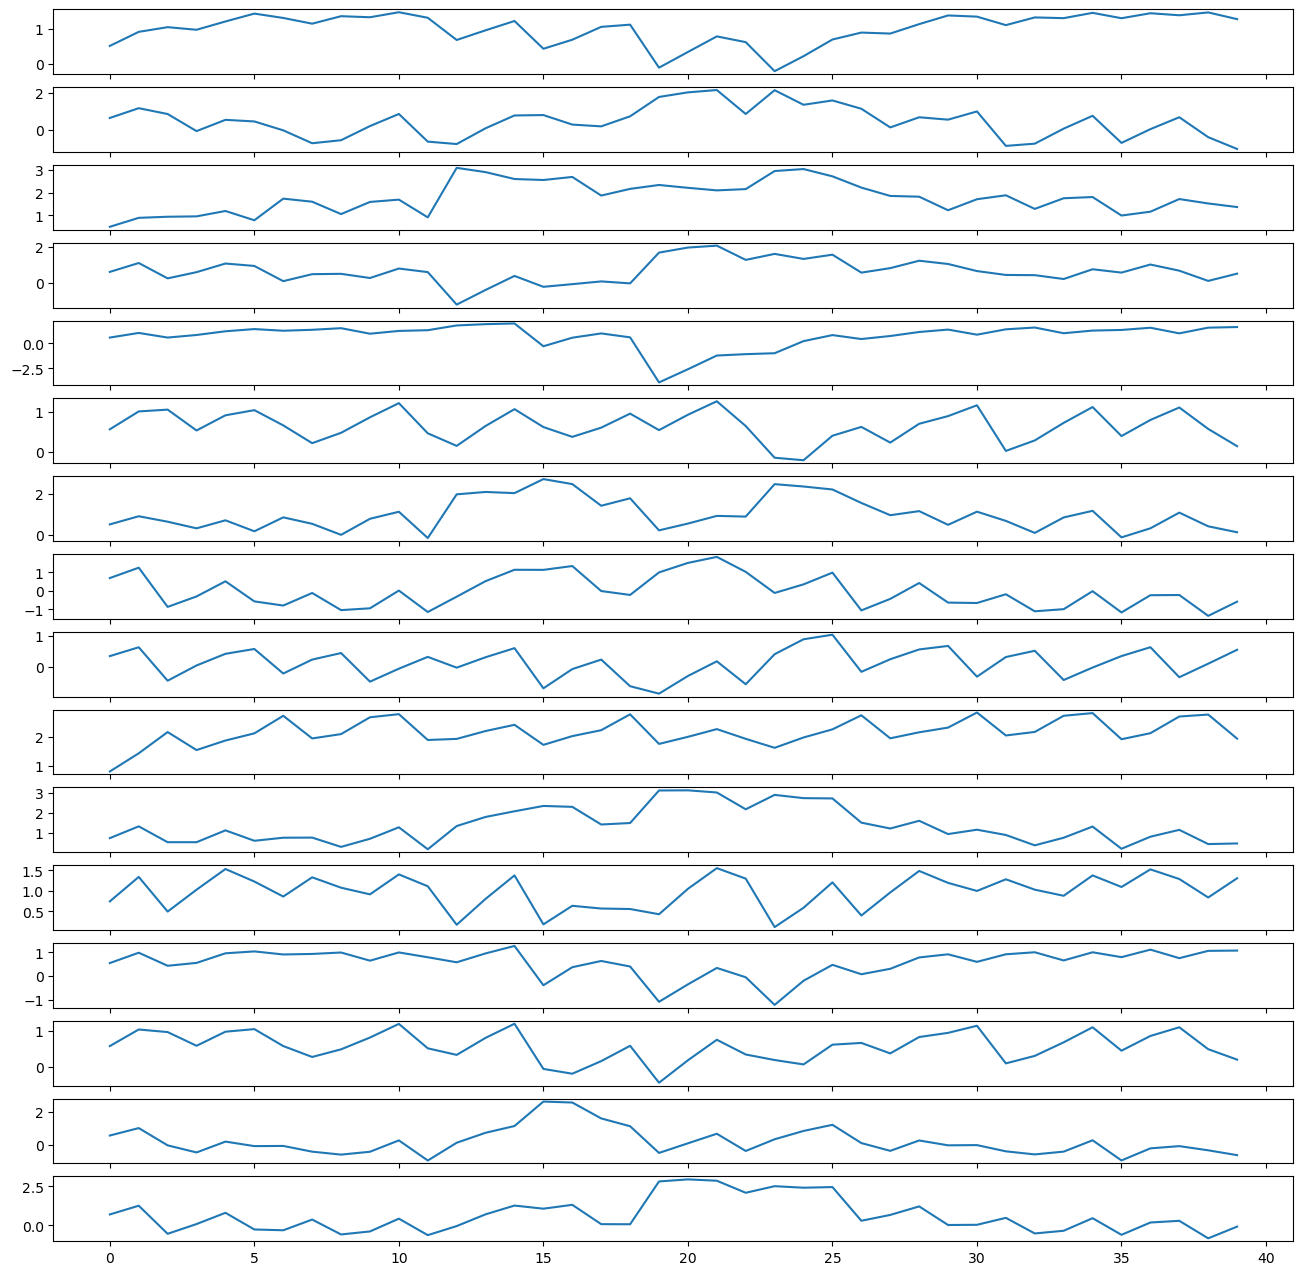


Input: [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Target: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Output: [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


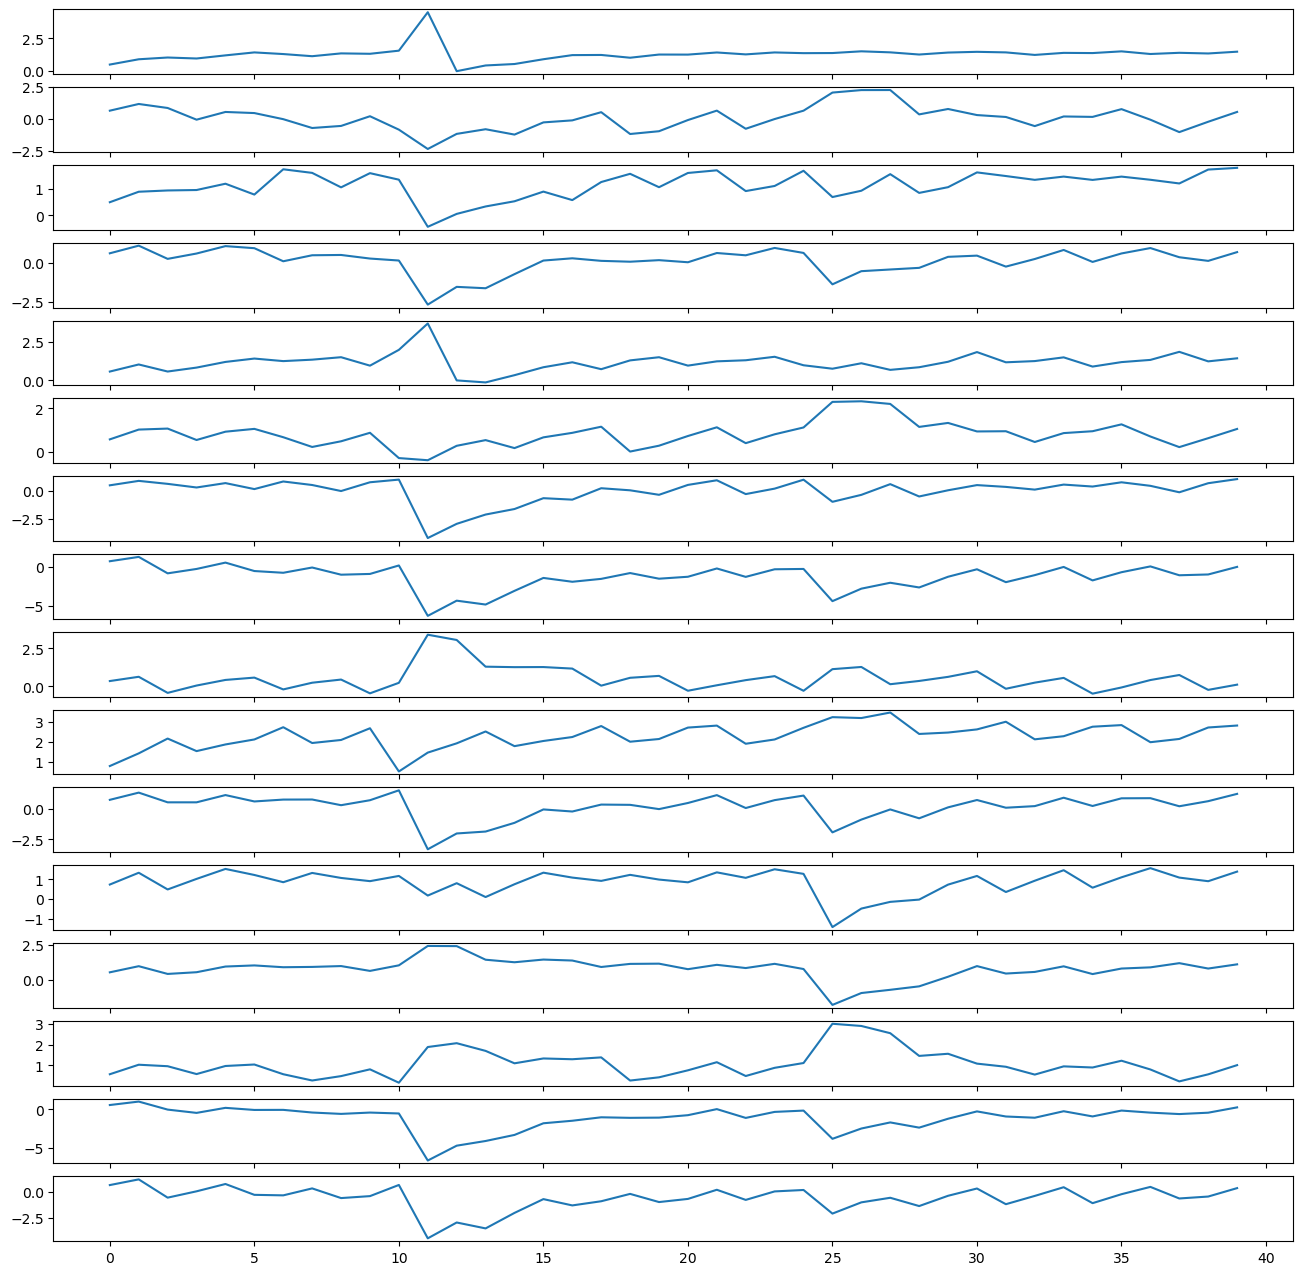


Input: [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
Target: [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


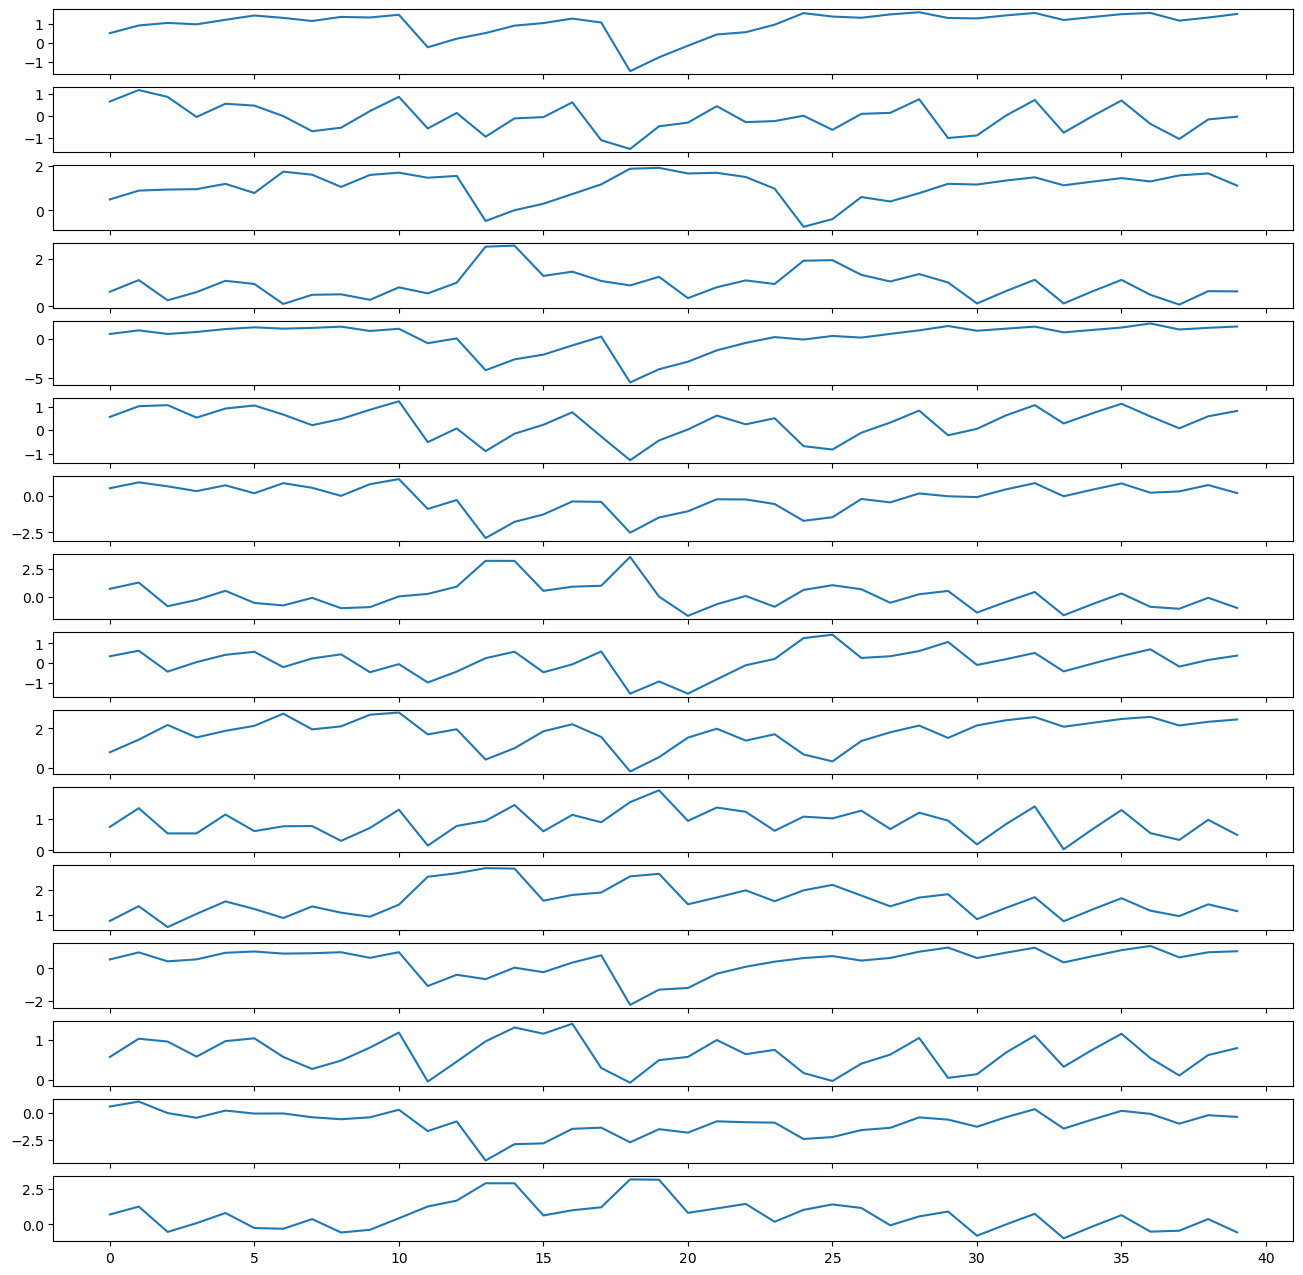


Input: [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0.]
Target: [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
Output: [0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.]


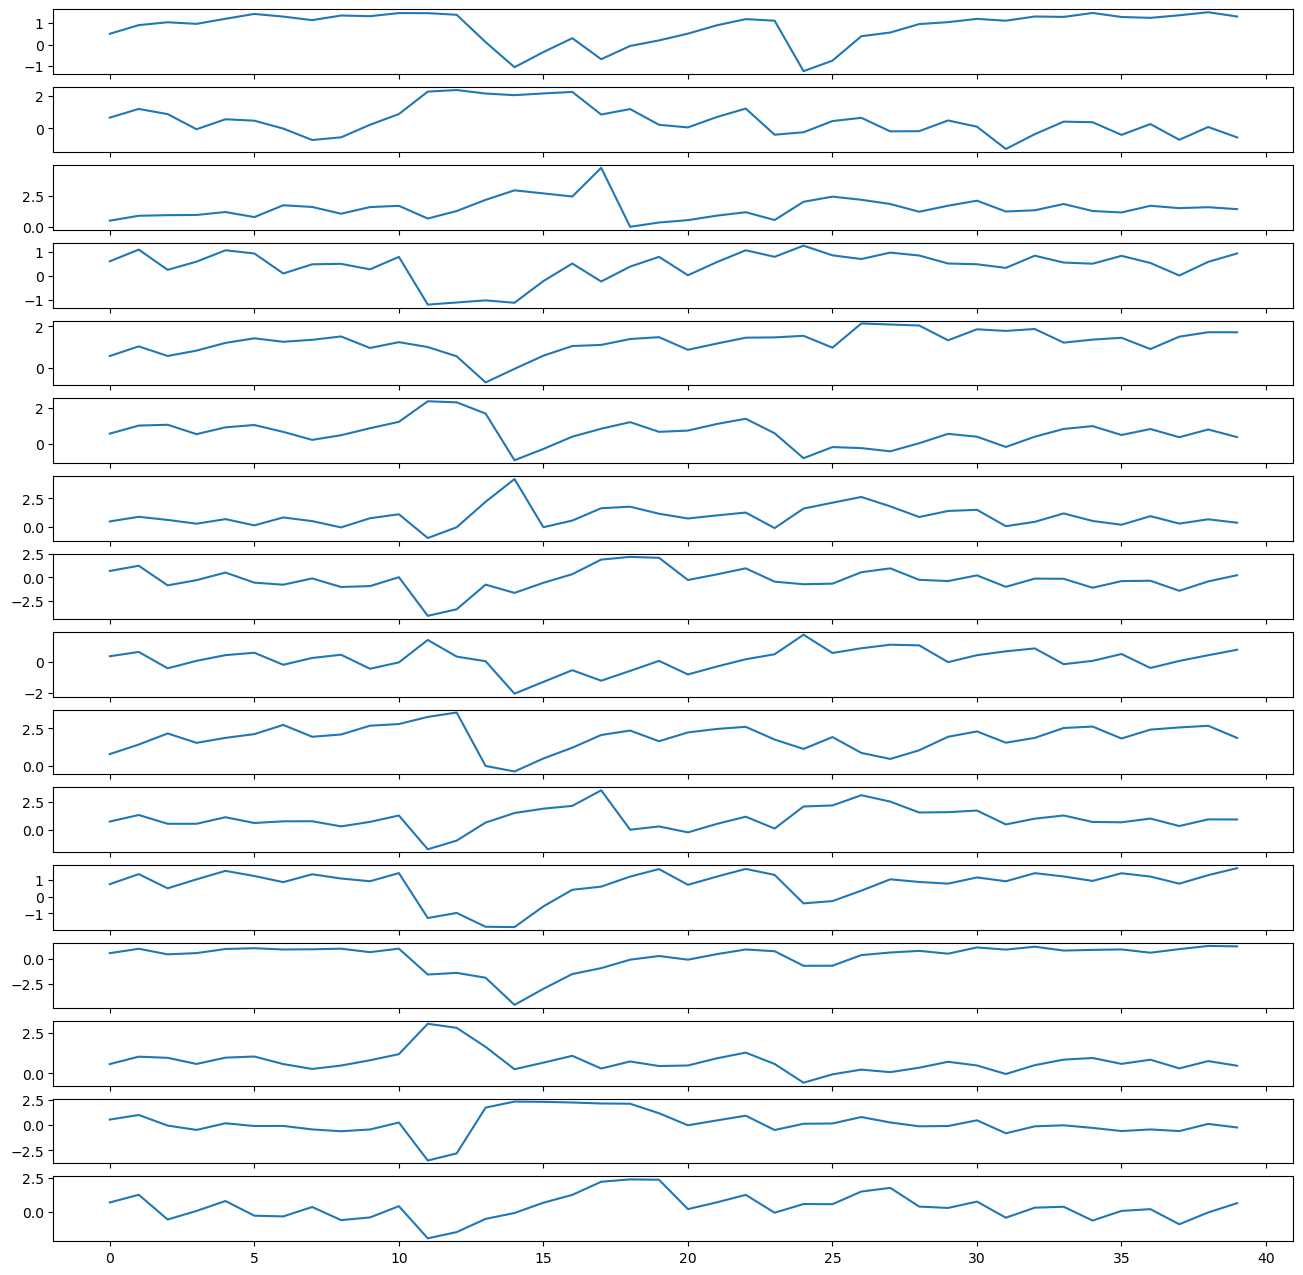


Input: [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Target: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Output: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


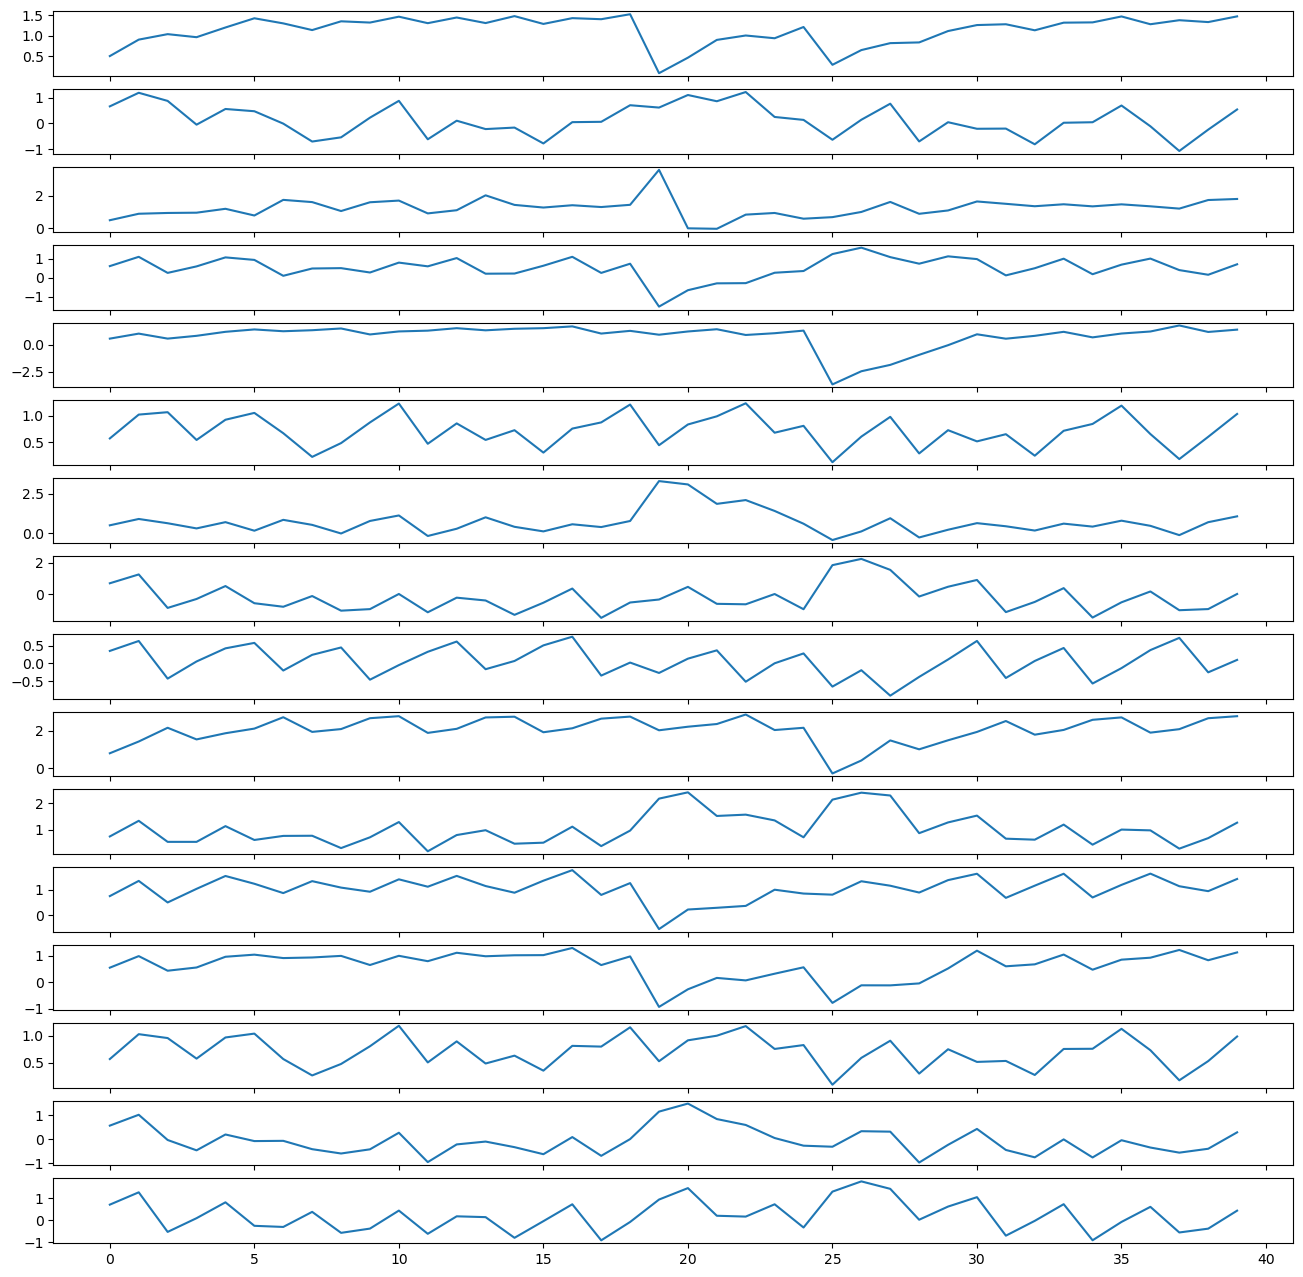

--------------------------



In [20]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-2, betas=(0.9, 0.999))

plot=True
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in train_batch:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        # create spike train
        spike_in = current_step(data_it, num_steps)
        spike_in = spike_in.to(device)
        
        #spike_target = current_step(targets_it, num_steps)
        #spike_target = spike_target.to(device)
        
        # forward pass
        net.train()
        spk_rec, mem_rec = net(spike_in.view(num_steps, batch_size, -1))
        
        #output decoding
        flatten_output = train_decoding(spk_rec)
        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=torch.float, device=device)
        loss_val += num_steps*loss(flatten_output, targets_it.view(batch_size,-1))
        
        
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
        
        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            #create spike train
            test_spike_in = current_step(test_data, num_steps)
            test_spike_in = test_spike_in.to(device)
            
            #spike_target_test = current_step(test_targets, num_steps)
            #spike_target_test = spike_target_test.to(device)
            
            # Test set forward pass
            test_spk, test_mem = net(test_spike_in.view(num_steps, batch_size, -1))
            
            
            #output decoding
            flatten_output_test = train_decoding(test_spk)
            # initialize the loss & sum over time
            test_loss = torch.zeros((1), dtype=torch.float, device=device)
            test_loss += num_steps*loss(flatten_output_test, test_targets.view(batch_size,-1))
            
            test_loss_hist.append(test_loss.item())
            # Print train/test loss
            if counter % 50 == 0:
                print('Iteration:',iter_counter)
                print('Train error:',loss_val.item())
                print('Test error:',test_loss.item())
                print('\nSome test examples:\n')
                print('Input:',train_decoding(test_spike_in).view(batch_size,-1)[0].numpy())
                print('Target:',test_targets.view(batch_size,-1)[0].numpy())
                print('Output:',flatten_output_test[0].numpy())
                if plot: rec_tensor_plot(test_mem,0)
                print('\nInput:',train_decoding(test_spike_in).view(batch_size,-1)[3].numpy())
                print('Target:',test_targets.view(batch_size,-1)[3].numpy())
                print('Output:',flatten_output_test[3].numpy())
                if plot :rec_tensor_plot(test_mem,3)
                print('\nInput:',train_decoding(test_spike_in).view(batch_size,-1)[30].numpy())
                print('Target:',test_targets.view(batch_size,-1)[30].numpy())
                print('Output:',flatten_output_test[30].numpy())
                if plot: rec_tensor_plot(test_mem,30)
                print('\nInput:',train_decoding(test_spike_in).view(batch_size,-1)[54].numpy())
                print('Target:',test_targets.view(batch_size,-1)[54].numpy())
                print('Output:',flatten_output_test[54].numpy())
                if plot: rec_tensor_plot(test_mem,54)
                print('\nInput:',train_decoding(test_spike_in).view(batch_size,-1)[23].numpy())
                print('Target:',test_targets.view(batch_size,-1)[23].numpy())
                print('Output:',flatten_output_test[23].numpy())
                if plot: rec_tensor_plot(test_mem,23)
                print('--------------------------\n')
            counter += 1
            iter_counter +=1

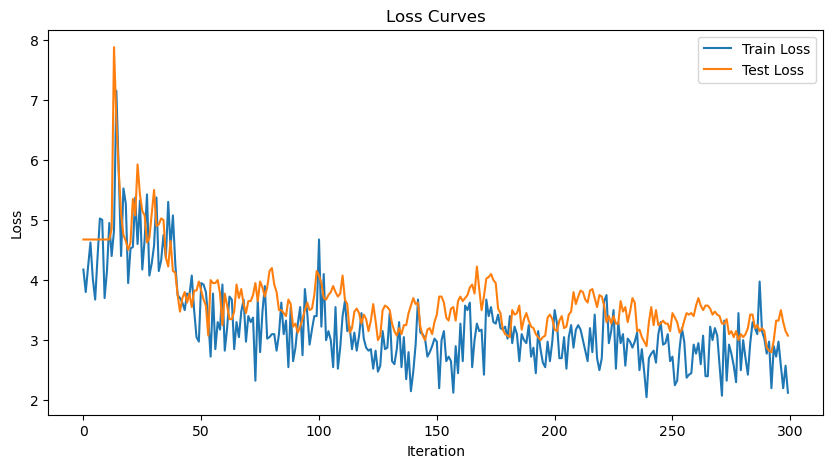

In [21]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [26]:
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
    net.eval()
    
    test_batch = iter(test_loader)

    # Minibatch loop
    for test_data, test_targets in test_batch:

        test_data = test_data.to(device)
        test_targets = test_targets.to(device)

        #create spike train
        test_spike_in = current_step(test_data, num_steps)
        test_spike_in = test_spike_in.to(device)
            
        # Test set forward pass
        test_spk, test_mem = net(test_spike_in.view(num_steps, batch_size, -1))
            
            
        #output decoding
        flatten_output_test = train_decoding(test_spk)
        correct += accuracy(flatten_output_test, test_targets.view(batch_size,-1))

print(f"Total correctly classified test set images: {correct}")
print(f"Test Set Accuracy: {100 * correct / num_events_test:.2f}%")

Total correctly classified test set images: 2822
Test Set Accuracy: 47.03%


### Additional test with 2 layers

In [232]:
class Net2order2layers(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden[0])
        self.lif_in = snn.Synaptic(beta=beta,alpha=alpha1,
                                   spike_grad=spike_grad,
                                   threshold=3.5)
        
        self.fc_hidden = nn.Linear(in_features=self.hidden[0], out_features=self.hidden[1])
        self.lif_hidden = snn.Synaptic(beta=beta,alpha=alpha1,
                                    spike_grad=spike_grad,
                                    threshold=3.5)
        
        self.fc_out = nn.Linear(in_features=self.hidden[1], out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=beta,alpha=alpha2,
                                    spike_grad=spike_grad,
                                    threshold=3.5,reset_mechanism = 'zero')
        
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        synh, memh = self.lif_hidden.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            
            curh = self.fc_hidden(spk1)
            spkh, synh, memh = self.lif_hidden(curh, synh, memh)
            
            cur2 = self.fc_out(spkh)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

num_hiddens =[16,100]
alpha1=0.
alpha2=0.1
beta=0.4
net = Net2order2layers(num_inputs, num_hiddens, num_outputs, num_steps).to(device)

In [233]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-2, betas=(0.9, 0.999))

plot=False
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in train_batch:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        # create spike train
        spike_in = current_step(data_it, num_steps)
        spike_in = spike_in.to(device)
        
        #spike_target = current_step(targets_it, num_steps)
        #spike_target = spike_target.to(device)
        
        # forward pass
        net.train()
        spk_rec, mem_rec = net(spike_in.view(num_steps, batch_size, -1))
        
        #output decoding
        flatten_output = train_decoding(spk_rec)
        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=torch.float, device=device)
        loss_val += num_steps*loss(flatten_output, targets_it.view(batch_size,-1))
        
        
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
        
        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            #create spike train
            test_spike_in = current_step(test_data, num_steps)
            test_spike_in = test_spike_in.to(device)
            
            #spike_target_test = current_step(test_targets, num_steps)
            #spike_target_test = spike_target_test.to(device)
            
            # Test set forward pass
            test_spk, test_mem = net(test_spike_in.view(num_steps, batch_size, -1))
            
            
            #output decoding
            flatten_output_test = train_decoding(test_spk)
            # initialize the loss & sum over time
            test_loss = torch.zeros((1), dtype=torch.float, device=device)
            test_loss += num_steps*loss(flatten_output_test, test_targets.view(batch_size,-1))
            
            test_loss_hist.append(test_loss.item())
            # Print train/test loss/accuracy
            if counter % 50 == 0:
                print('Iteration:',iter_counter)
                print('Train error:',loss_val.item())
                print('Test error:',test_loss.item())
                print('\nSome test examples:\n')
                print('Input:',train_decoding(test_spike_in).view(batch_size,-1)[0].numpy())
                print('Target:',test_targets.view(batch_size,-1)[0].numpy())
                print('Output:',flatten_output_test[0].numpy())
                if plot: rec_tensor_plot(test_mem,0)
                print('\nInput:',train_decoding(test_spike_in).view(batch_size,-1)[3].numpy())
                print('Target:',test_targets.view(batch_size,-1)[3].numpy())
                print('Output:',flatten_output_test[3].numpy())
                if plot :rec_tensor_plot(test_mem,3)
                print('\nInput:',train_decoding(test_spike_in).view(batch_size,-1)[30].numpy())
                print('Target:',test_targets.view(batch_size,-1)[30].numpy())
                print('Output:',flatten_output_test[30].numpy())
                if plot: rec_tensor_plot(test_mem,30)
                print('\nInput:',train_decoding(test_spike_in).view(batch_size,-1)[54].numpy())
                print('Target:',test_targets.view(batch_size,-1)[54].numpy())
                print('Output:',flatten_output_test[54].numpy())
                if plot: rec_tensor_plot(test_mem,54)
                print('\nInput:',train_decoding(test_spike_in).view(batch_size,-1)[23].numpy())
                print('Target:',test_targets.view(batch_size,-1)[23].numpy())
                print('Output:',flatten_output_test[23].numpy())
                if plot: rec_tensor_plot(test_mem,23)
                print('--------------------------\n')
            counter += 1
            iter_counter +=1

Iteration: 0
Train error: 5.0
Test error: 3.7750000953674316

Some test examples:

Input: [0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0.]
Target: [0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
Output: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Input: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Target: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Input: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
Target: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Input: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Target: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Input: [1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
Target: [1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
Output: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
--------------------------

Iteration: 50
Train 